In [1]:
using Knet
using AutoGrad
using Images
using ImageMagick
using Random
using PyPlot
using Statistics
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
import CUDA
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

Start by loading list of images to be used

In [294]:
dataPath = "GeNeVA-v1\\i-CLEVR\\images"
files = readdir(dataPath);

Select images containing single object

In [295]:
singleObj = files[endswith.(files, "_0.png")]
singleObj = ["$(dataPath)\\$(file)" for file in singleObj];

Create iterator for Clevr Dataset

In [401]:
struct ClevrData
    files
    batchsize::Int
    #shuffle::Bool
    num_instances::Int

    function ClevrData(files; batchsize::Int=1) #shuffle::Bool=false)
        new(files, batchsize, length(files))
    end
end

In [402]:
function length(d::ClevrData)
    nFullBatches, rem = divrem(d.num_instances, d.batchsize)
    nFullBatches + (rem > 0)*1
end

length (generic function with 204 methods)

In [403]:
function load_image(filename)
    img = load(filename)
    img = imresize(img, (64,64))
    img = Float64.(channelview(img))
    img = img[1:3,:,:]
    img = permutedims(img, [2, 3, 1])
#     img = reshape(img, (64,64,3,1))
#     img = convert(array_type, img)
end

load_image (generic function with 1 method)

In [404]:
function iterate(d::ClevrData, state=collect(1:d.num_instances))
    if length(state) > 0
        batch = d.files[state[1:(length(state) < d.batchsize ? end : d.batchsize)]]
        state  = state[d.batchsize+1:end]
        out = convert(array_type, zeros(64,64,3,length(batch)))
        ims = load_image.(batch)
        for i in collect(1:length(batch)); out[:,:,:,i] = ims[i]; end
        return (Param(out)), state
    end
end

iterate (generic function with 422 methods)

In [496]:
?sgd!

search: sgd! sgd Sgd SGD signed Signed using3D Unsigned unsigned colorsigned



```
minimize(func, data, optimizer=Adam(); params)
sgd     (func, data; lr=0.1,  gclip, params)
momentum(func, data; lr=0.05, gamma=0.95, gclip, params)
nesterov(func, data; lr=0.05, gamma=0.95, gclip, params)
adagrad (func, data; lr=0.05, eps=1e-6, gclip, params)
rmsprop (func, data; lr=0.01, rho=0.9, eps=1e-6, gclip, params)
adadelta(func, data; lr=1.0,  rho=0.9, eps=1e-6, gclip, params)
adam    (func, data; lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, gclip, params)
```

Return an iterator which applies `func` to arguments in `data`, i.e.  `(func(args...) for args in data)`, and updates the parameters every iteration to minimize `func`.  `func` should return a scalar value.

The common keyword argument `params` can be used to list the `Param`s to be optimized.  If not specified, any `Param` that takes part in the computation of `func(args...)` will be updated.

The common keyword argument `gclip` can be used to implement per-parameter gradient clipping. For a parameter gradient `g`, if `norm(g) > gclip > 0`, `g` is scaled so that its norm is equal to `gclip`. If not specified no gradient clipping is performed.

These functions do not perform optimization, but return an iterator that can. Any function that produces values from an iterator can be used with such an object, e.g. `progress!(sgd(f,d))` iterates the sgd optimizer and displays a progress bar. For convenience, appending `!` to the name of the function iterates and returns `nothing`, i.e. `sgd!(...)` is equivalent to `(for x in sgd(...) end)`.

We define optimizers as lazy iterators to have explicit control over them:

  * To report progress use `progress(sgd(f,d))`.
  * To run until convergence use `converge(sgd(f,cycle(d)))`.
  * To run multiple epochs use `sgd(f,repeat(d,n))`.
  * To run a given number of iterations use `sgd(f,take(cycle(d),n))`.
  * To do a task every n iterations use `(task() for (i,j) in enumerate(sgd(f,d)) if i%n == 1)`.

These functions apply the same algorithm with the same configuration to every parameter by default. `minimize` takes an explicit optimizer argument, all others call `minimize` with an appropriate optimizer argument (see `@doc update!` for a list of possible optimizers). Before calling [`update!`](@ref) on a `Param`, `minimize` sets its `opt` field to a copy of this default optimizer if it is not already set. The `opt` field is used by the `update!` function to determine the type of update performed on that parameter.  If you need finer grained control, you can set the optimizer of an individual `Param` by setting its `opt` field before calling one of these functions. They will not override the `opt` field if it is already set, e.g. `sgd(model,data)` will perform an `Adam` update for a parameter whose `opt` field is an `Adam` object. This also means you can stop and start the training without losing optimization state, the first call will set the `opt` fields and the subsequent calls will not override them.

Given a parameter `w` and its gradient `g` here are the updates applied by each optimizer:

```
# sgd (http://en.wikipedia.org/wiki/Stochastic_gradient_descent)
w .= w - lr * g

# momentum (http://jlmelville.github.io/mize/nesterov.html)
v .= gamma * v - lr * g
w .= w + v

# nesterov (http://jlmelville.github.io/mize/nesterov.html)
w .= w - gamma * v
v .= gamma * v - lr * g
w .= w + (1 + gamma) * v

# adagrad (http://www.jmlr.org/papers/v12/duchi11a.html)
G .= G + g .^ 2
w .= w - lr * g ./ sqrt(G + eps)

# rmsprop (http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
G .= rho * G + (1-rho) * g .^ 2 
w .= w - lr * g ./ sqrt(G + eps)

# adadelta (http://arxiv.org/abs/1212.5701)
G .= rho * G + (1-rho) * g .^ 2
update = sqrt(delta + eps) .* g ./ sqrt(G + eps)
w = w - lr * update
delta = rho * delta + (1-rho) * update .^ 2

# adam (http://arxiv.org/abs/1412.6980)
v = beta1 * v + (1 - beta1) * g
G = beta2 * G + (1 - beta2) * g .^ 2
vhat = v ./ (1 - beta1 ^ t)
Ghat = G ./ (1 - beta2 ^ t)
w = w - (lr / (sqrt(Ghat) + eps)) * vhat
```


In [198]:
# for batch in clevrDataset
#     println(length(batch))
# end

In [105]:
struct Dense; w; b; f; end
Dense(i::Int,o::Int,f=relu) = Dense(param(o,i), param0(o), f)
(d::Dense)(x) = d.f.(d.w * mat(x) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul

In [128]:
struct Discriminator2
    layers
    Discriminator2(layers...) = new(layers)
end
(model::Discriminator2)(x) = (for l in model.layers; x = l(x); end; x)


In [373]:
function Z(dim1, dim2)
    z = (rand(dim1, dim2).*2.0).-1.0
    Param(convert(array_type, z))
end

Z (generic function with 3 methods)

In [377]:
struct Generator2
    layers
    Generator2(layers...) = new(layers)
end
(model::Generator2)(x) = (for l in model.layers; x = l(x); end; x)

In [392]:
struct Reshape1; x; y; c; end;
Reshape1() = Reshape1(64,64,3)
(r::Reshape1)(x) = reshape(x, r.x, r.y, r.c) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul

In [424]:
struct Reshape2; a end;
Reshape2() = Reshape2(1)
(r::Reshape2)(x) = reshape(x, :,1) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul

In [399]:
function dLoss(D::Discriminator2, realIms, fakeIms)
    realLoss = -mean(log.(D(realIms)))
    fakeLoss = -mean(log.(1 .- D(fakeIms)))
    return 0.5*(realLoss+fakeLoss)
end

dLoss (generic function with 2 methods)

In [398]:
function gLoss(G::Generator2, D::Discriminator2, z)
    yPr = D(G(z))
    return -0.5*mean(log.(yPr))
end

gLoss (generic function with 2 methods)

In [449]:
function main()
    clevrDataset = ClevrData(singleObj)
    G = Generator2(Dense(128, 12288), Reshape1())
    D = Discriminator2(Reshape2(), Dense(12288, 1, sigm))
    loss_g = []
    loss_d = []
    for real_image in clevrDataset
        z = Z(128,1)
        sgd!(dLoss, [(D, real_image, G(z))])
        sgd!(gLoss, [(G, D, z)])
        push!(loss_g, gLoss(G, D, z))
        push!(loss_d, dLoss(D, real_image, G(z)))
        print("GenLoss: ");println(loss_g[end])
        print("DisLoss: ");println(loss_d[end])
    end
end

main (generic function with 1 method)

In [450]:
main()

GenLoss: 0.011156252585351467
DisLoss: 1.9068708419799805
GenLoss: 0.0295269712805748
DisLoss: 1.429342269897461
GenLoss: 0.03867523372173309
DisLoss: 1.2989169359207153
GenLoss: 0.04109540581703186
DisLoss: 1.2697625160217285
GenLoss: 0.042480841279029846
DisLoss: 1.253867268562317
GenLoss: 0.03235234320163727
DisLoss: 1.3850493431091309
GenLoss: 0.04380505532026291
DisLoss: 1.2391718626022339
GenLoss: 0.03197817876935005
DisLoss: 1.3906807899475098
GenLoss: 0.05507278069853783
DisLoss: 1.1302595138549805
GenLoss: 0.03267815336585045
DisLoss: 1.3802003860473633
GenLoss: 0.05297469347715378
DisLoss: 1.1486502885818481
GenLoss: 0.05460386350750923
DisLoss: 1.1343048810958862
GenLoss: 0.03495260700583458
DisLoss: 1.3476817607879639
GenLoss: 0.05624621734023094
DisLoss: 1.1202939748764038
GenLoss: 0.02599960006773472
DisLoss: 1.491207242012024
GenLoss: 0.03887815773487091
DisLoss: 1.2964009046554565
GenLoss: 0.04277072474360466
DisLoss: 1.2506104707717896
GenLoss: 0.04269814118742943
DisL

DisLoss: 0.8210610151290894
GenLoss: 0.1008363887667656
DisLoss: 0.8539690375328064
GenLoss: 0.11435085535049438
DisLoss: 0.7952012419700623
GenLoss: 0.1254407912492752
DisLoss: 0.7541407942771912
GenLoss: 0.10567986965179443
DisLoss: 0.830524206161499
GenLoss: 0.11147233843803406
DisLoss: 0.8082297444343567
GenLoss: 0.10576245933771133
DisLoss: 0.830242931842804
GenLoss: 0.09937752783298492
DisLoss: 0.8582688570022583
GenLoss: 0.08033117651939392
DisLoss: 0.956158459186554
GenLoss: 0.10822047293186188
DisLoss: 0.8193355202674866
GenLoss: 0.0985763669013977
DisLoss: 0.8614889979362488
GenLoss: 0.09939398616552353
DisLoss: 0.859169065952301
GenLoss: 0.12322225421667099
DisLoss: 0.7623283267021179
GenLoss: 0.12397441267967224
DisLoss: 0.7581759095191956
GenLoss: 0.10118001699447632
DisLoss: 0.8487321138381958
GenLoss: 0.09131297469139099
DisLoss: 0.8954103589057922
GenLoss: 0.11607664078474045
DisLoss: 0.7881139516830444
GenLoss: 0.12274832278490067
DisLoss: 0.7634484767913818
GenLoss: 0

GenLoss: 0.1509162336587906
DisLoss: 0.6726983189582825
GenLoss: 0.14049476385116577
DisLoss: 0.7034690380096436
GenLoss: 0.11104635894298553
DisLoss: 0.8070281147956848
GenLoss: 0.12816312909126282
DisLoss: 0.7440024614334106
GenLoss: 0.13595257699489594
DisLoss: 0.7184048891067505
GenLoss: 0.16046851873397827
DisLoss: 0.6465400457382202
GenLoss: 0.14250515401363373
DisLoss: 0.6973637342453003
GenLoss: 0.13153424859046936
DisLoss: 0.7321613430976868
GenLoss: 0.10450614988803864
DisLoss: 0.8342982530593872
GenLoss: 0.14029784500598907
DisLoss: 0.704278826713562
GenLoss: 0.14737950265407562
DisLoss: 0.6834185123443604
GenLoss: 0.13226564228534698
DisLoss: 0.7297758460044861
GenLoss: 0.12541420757770538
DisLoss: 0.7532967925071716
GenLoss: 0.15200014412403107
DisLoss: 0.6697867512702942
GenLoss: 0.13840501010417938
DisLoss: 0.7100684642791748
GenLoss: 0.12276672571897507
DisLoss: 0.76253342628479
GenLoss: 0.13323090970516205
DisLoss: 0.726495087146759
GenLoss: 0.1266694813966751
DisLoss:

GenLoss: 0.13752590119838715
DisLoss: 0.7127366065979004
GenLoss: 0.11854620277881622
DisLoss: 0.7779535055160522
GenLoss: 0.12267328053712845
DisLoss: 0.7626848816871643
GenLoss: 0.13378815352916718
DisLoss: 0.724713921546936
GenLoss: 0.12357054650783539
DisLoss: 0.7595248222351074
GenLoss: 0.158199742436409
DisLoss: 0.6525200009346008
GenLoss: 0.13553613424301147
DisLoss: 0.7190468311309814
GenLoss: 0.11776400357484818
DisLoss: 0.7807875275611877
GenLoss: 0.12882186472415924
DisLoss: 0.7412810921669006
GenLoss: 0.11827007681131363
DisLoss: 0.778851330280304
GenLoss: 0.11642034351825714
DisLoss: 0.7858424186706543
GenLoss: 0.12753097712993622
DisLoss: 0.7455994486808777
GenLoss: 0.12122456729412079
DisLoss: 0.767919659614563
GenLoss: 0.1106586754322052
DisLoss: 0.8084484934806824
GenLoss: 0.13911016285419464
DisLoss: 0.7076701521873474
GenLoss: 0.11300129443407059
DisLoss: 0.7991217970848083
GenLoss: 0.12163855135440826
DisLoss: 0.7664571404457092
GenLoss: 0.12751343846321106
DisLoss:

DisLoss: 0.7973142862319946
GenLoss: 0.10134910047054291
DisLoss: 0.8478606343269348
GenLoss: 0.10721176117658615
DisLoss: 0.8225735425949097
GenLoss: 0.10851626098155975
DisLoss: 0.8172304630279541
GenLoss: 0.12161282449960709
DisLoss: 0.7665195465087891
GenLoss: 0.13576990365982056
DisLoss: 0.7182448506355286
GenLoss: 0.1258661150932312
DisLoss: 0.7513707876205444
GenLoss: 0.1239701360464096
DisLoss: 0.7580529451370239
GenLoss: 0.11742636561393738
DisLoss: 0.7820519804954529
GenLoss: 0.12016326934099197
DisLoss: 0.7718740701675415
GenLoss: 0.08641548454761505
DisLoss: 0.9203486442565918
GenLoss: 0.11141084879636765
DisLoss: 0.805399477481842
GenLoss: 0.13119427859783173
DisLoss: 0.7332148551940918
GenLoss: 0.12153104692697525
DisLoss: 0.7668684720993042
GenLoss: 0.13144248723983765
DisLoss: 0.7324402928352356
GenLoss: 0.10552294552326202
DisLoss: 0.8297558426856995
GenLoss: 0.10961836576461792
DisLoss: 0.8126607537269592
GenLoss: 0.11826577037572861
DisLoss: 0.7788307070732117
GenLos

GenLoss: 0.1341550350189209
DisLoss: 0.7234652042388916
GenLoss: 0.1383732408285141
DisLoss: 0.7100115418434143
GenLoss: 0.11468882858753204
DisLoss: 0.7924700379371643
GenLoss: 0.11276426166296005
DisLoss: 0.8000591397285461
GenLoss: 0.09299523383378983
DisLoss: 0.8868277668952942
GenLoss: 0.11620564013719559
DisLoss: 0.7866397500038147
GenLoss: 0.11269260942935944
DisLoss: 0.8003219962120056
GenLoss: 0.08908697962760925
DisLoss: 0.9064479470252991
GenLoss: 0.11073170602321625
DisLoss: 0.8081420063972473
GenLoss: 0.10476438701152802
DisLoss: 0.8329339623451233
GenLoss: 0.11386276036500931
DisLoss: 0.795677125453949
GenLoss: 0.10779877007007599
DisLoss: 0.8201128840446472
GenLoss: 0.11534874886274338
DisLoss: 0.7899083495140076
GenLoss: 0.10050750523805618
DisLoss: 0.8516430258750916
GenLoss: 0.11010310053825378
DisLoss: 0.8106769919395447
GenLoss: 0.1078910306096077
DisLoss: 0.8197602033615112
GenLoss: 0.12680503726005554
DisLoss: 0.7481262683868408
GenLoss: 0.10939113795757294
DisLos

GenLoss: 0.08623318374156952
DisLoss: 0.9212901592254639
GenLoss: 0.10002900660037994
DisLoss: 0.8537756204605103
GenLoss: 0.12040124833583832
DisLoss: 0.7709081768989563
GenLoss: 0.0882936418056488
DisLoss: 0.910478949546814
GenLoss: 0.10536268353462219
DisLoss: 0.830376386642456
GenLoss: 0.10762391984462738
DisLoss: 0.8208485841751099
GenLoss: 0.11833248287439346
DisLoss: 0.7785811424255371
GenLoss: 0.10620788484811783
DisLoss: 0.8268149495124817
GenLoss: 0.09761213511228561
DisLoss: 0.8648269772529602
GenLoss: 0.11182767897844315
DisLoss: 0.8037316203117371
GenLoss: 0.11799989640712738
DisLoss: 0.7798202037811279
GenLoss: 0.09394857287406921
DisLoss: 0.8822049498558044
GenLoss: 0.09605123847723007
DisLoss: 0.8721481561660767
GenLoss: 0.0970584824681282
DisLoss: 0.8674082159996033
GenLoss: 0.10355304926633835
DisLoss: 0.8381760120391846
GenLoss: 0.11516749113798141
DisLoss: 0.790665328502655
GenLoss: 0.10705110430717468
DisLoss: 0.823233425617218
GenLoss: 0.09677467495203018
DisLoss:

DisLoss: 0.877342164516449
GenLoss: 0.10730328410863876
DisLoss: 0.822182297706604
GenLoss: 0.08416690677404404
DisLoss: 0.9324046969413757
GenLoss: 0.11312564462423325
DisLoss: 0.7985621094703674
GenLoss: 0.10802756994962692
DisLoss: 0.8191738128662109
GenLoss: 0.11913678795099258
DisLoss: 0.7755939364433289
GenLoss: 0.08614979684352875
DisLoss: 0.9217349886894226
GenLoss: 0.08617493510246277
DisLoss: 0.9215916395187378
GenLoss: 0.10366109758615494
DisLoss: 0.8377048969268799
GenLoss: 0.08322527259588242
DisLoss: 0.9375820755958557
GenLoss: 0.10510380566120148
DisLoss: 0.8314893245697021
GenLoss: 0.11887197196483612
DisLoss: 0.7765641808509827
GenLoss: 0.09353461116552353
DisLoss: 0.884196400642395
GenLoss: 0.08317704498767853
DisLoss: 0.9378407001495361
GenLoss: 0.10069865733385086
DisLoss: 0.8507542014122009
GenLoss: 0.09732623398303986
DisLoss: 0.8661597371101379
GenLoss: 0.12442366033792496
DisLoss: 0.7564083337783813
GenLoss: 0.09583879262208939
DisLoss: 0.8731365203857422
GenLos

DisLoss: 0.88643479347229
GenLoss: 0.10773728787899017
DisLoss: 0.8203885555267334
GenLoss: 0.10677511245012283
DisLoss: 0.8243940472602844
GenLoss: 0.10354533791542053
DisLoss: 0.8381983041763306
GenLoss: 0.11179439723491669
DisLoss: 0.8038462996482849
GenLoss: 0.07942076772451401
DisLoss: 0.9591223001480103
GenLoss: 0.10904039442539215
DisLoss: 0.8149912357330322
GenLoss: 0.09100255370140076
DisLoss: 0.896696925163269
GenLoss: 0.09687095880508423
DisLoss: 0.8682959079742432
GenLoss: 0.09017197787761688
DisLoss: 0.9008673429489136
GenLoss: 0.10492062568664551
DisLoss: 0.8322564363479614
GenLoss: 0.12565815448760986
DisLoss: 0.7520769834518433
GenLoss: 0.09740088880062103
DisLoss: 0.865818202495575
GenLoss: 0.12240909785032272
DisLoss: 0.7636067867279053
GenLoss: 0.10096956789493561
DisLoss: 0.849550187587738
GenLoss: 0.08692274987697601
DisLoss: 0.9176402688026428
GenLoss: 0.09521883726119995
DisLoss: 0.8760859370231628
GenLoss: 0.10537195950746536
DisLoss: 0.830325722694397
GenLoss: 

DisLoss: 0.858978807926178
GenLoss: 0.08530059456825256
DisLoss: 0.926263153553009
GenLoss: 0.09991860389709473
DisLoss: 0.8542717695236206
GenLoss: 0.09664752334356308
DisLoss: 0.8693263530731201
GenLoss: 0.0952506735920906
DisLoss: 0.8759264349937439
GenLoss: 0.09487538784742355
DisLoss: 0.8777232766151428
GenLoss: 0.10999306291341782
DisLoss: 0.8111057877540588
GenLoss: 0.09607692062854767
DisLoss: 0.8720119595527649
GenLoss: 0.09671290963888168
DisLoss: 0.8690271377563477
GenLoss: 0.0883956104516983
DisLoss: 0.9099524617195129
GenLoss: 0.1088717058300972
DisLoss: 0.8156923055648804
GenLoss: 0.0734923854470253
DisLoss: 0.9950140714645386
GenLoss: 0.0926511287689209
DisLoss: 0.8885102868080139
GenLoss: 0.09287765622138977
DisLoss: 0.8873934745788574
GenLoss: 0.08469617366790771
DisLoss: 0.9295403957366943
GenLoss: 0.10010305792093277
DisLoss: 0.8534289002418518
GenLoss: 0.10113883018493652
DisLoss: 0.8487865328788757
GenLoss: 0.10361669212579727
DisLoss: 0.837878942489624
GenLoss: 0.

GenLoss: 0.09344008564949036
DisLoss: 0.8846549987792969
GenLoss: 0.10287471115589142
DisLoss: 0.8411228656768799
GenLoss: 0.10011951625347137
DisLoss: 0.8533631563186646
GenLoss: 0.11634349822998047
DisLoss: 0.786102831363678
GenLoss: 0.08025208860635757
DisLoss: 0.9543192386627197
GenLoss: 0.10960089415311813
DisLoss: 0.8126865029335022
GenLoss: 0.11021532863378525
DisLoss: 0.8102002739906311
GenLoss: 0.09389517456293106
DisLoss: 0.8824481964111328
GenLoss: 0.10314951092004776
DisLoss: 0.839928388595581
GenLoss: 0.12264597415924072
DisLoss: 0.7627353668212891
GenLoss: 0.08597166836261749
DisLoss: 0.9226783514022827
GenLoss: 0.10998132824897766
DisLoss: 0.8111447691917419
GenLoss: 0.1185741126537323
DisLoss: 0.7776637673377991
GenLoss: 0.10761050134897232
DisLoss: 0.8208922743797302
GenLoss: 0.09501560032367706
DisLoss: 0.8770530223846436
GenLoss: 0.07866012305021286
DisLoss: 0.9635663628578186
GenLoss: 0.09965506941080093
DisLoss: 0.8554537296295166
GenLoss: 0.10506883263587952
DisLo

DisLoss: 0.8872785568237305
GenLoss: 0.09062127023935318
DisLoss: 0.8986031413078308
GenLoss: 0.0933704674243927
DisLoss: 0.8849819302558899
GenLoss: 0.09764241427183151
DisLoss: 0.8646897673606873
GenLoss: 0.0923331081867218
DisLoss: 0.8900740146636963
GenLoss: 0.10483457893133163
DisLoss: 0.8326227068901062
GenLoss: 0.09531126171350479
DisLoss: 0.8756442070007324
GenLoss: 0.11796820163726807
DisLoss: 0.7799412608146667
GenLoss: 0.09655895084142685
DisLoss: 0.8697377443313599
GenLoss: 0.09913236647844315
DisLoss: 0.8578392863273621
GenLoss: 0.10994943231344223
DisLoss: 0.8112831711769104
GenLoss: 0.11376677453517914
DisLoss: 0.7960454225540161
GenLoss: 0.10105390101671219
DisLoss: 0.849174976348877
GenLoss: 0.10700330883264542
DisLoss: 0.8234401941299438
GenLoss: 0.09664333611726761
DisLoss: 0.8693464994430542
GenLoss: 0.08545175194740295
DisLoss: 0.9254547953605652
GenLoss: 0.09826420247554779
DisLoss: 0.8618237972259521
GenLoss: 0.09865117818117142
DisLoss: 0.8600364923477173
GenLos

GenLoss: 0.10117239505052567
DisLoss: 0.8486438989639282
GenLoss: 0.13157930970191956
DisLoss: 0.7318670153617859
GenLoss: 0.09131941944360733
DisLoss: 0.8950963020324707
GenLoss: 0.09187500923871994
DisLoss: 0.892335057258606
GenLoss: 0.11844256520271301
DisLoss: 0.7781574726104736
GenLoss: 0.09921038895845413
DisLoss: 0.8574820756912231
GenLoss: 0.09071008861064911
DisLoss: 0.8981508016586304
GenLoss: 0.08868355304002762
DisLoss: 0.9084667563438416
GenLoss: 0.09447958320379257
DisLoss: 0.8796204924583435
GenLoss: 0.10161853581666946
DisLoss: 0.8466580510139465
GenLoss: 0.1047496497631073
DisLoss: 0.832994282245636
GenLoss: 0.10629814863204956
DisLoss: 0.8263984322547913
GenLoss: 0.09066806733608246
DisLoss: 0.8983588218688965
GenLoss: 0.10590051859617233
DisLoss: 0.8280803561210632
GenLoss: 0.0837106704711914
DisLoss: 0.9349043965339661
GenLoss: 0.08569584786891937
DisLoss: 0.9241480231285095
GenLoss: 0.1024148017168045
DisLoss: 0.8431347608566284
GenLoss: 0.09364195913076401
DisLoss

DisLoss: 0.9124307632446289
GenLoss: 0.09836951643228531
DisLoss: 0.8613288402557373
GenLoss: 0.10678216069936752
DisLoss: 0.824357807636261
GenLoss: 0.09588567912578583
DisLoss: 0.8729075193405151
GenLoss: 0.08162801712751389
DisLoss: 0.9464862942695618
GenLoss: 0.09488577395677567
DisLoss: 0.8776684999465942
GenLoss: 0.09736711531877518
DisLoss: 0.8659655451774597
GenLoss: 0.0955115482211113
DisLoss: 0.8746904134750366
GenLoss: 0.10722745954990387
DisLoss: 0.8224994540214539
GenLoss: 0.0921042338013649
DisLoss: 0.8912075161933899
GenLoss: 0.12622223794460297
DisLoss: 0.7500775456428528
GenLoss: 0.07951712608337402
DisLoss: 0.9585635662078857
GenLoss: 0.10774627327919006
DisLoss: 0.8203305006027222
GenLoss: 0.10293113440275192
DisLoss: 0.8408735990524292
GenLoss: 0.10503698885440826
DisLoss: 0.8317596912384033
GenLoss: 0.09240508824586868
DisLoss: 0.8897159099578857
GenLoss: 0.09690181910991669
DisLoss: 0.8681347966194153
GenLoss: 0.10986685752868652
DisLoss: 0.8116106390953064
GenLos

GenLoss: 0.10097318887710571
DisLoss: 0.8495295643806458
GenLoss: 0.10391408950090408
DisLoss: 0.8365876078605652
GenLoss: 0.11273794621229172
DisLoss: 0.8000983595848083
GenLoss: 0.08926135301589966
DisLoss: 0.9055057168006897
GenLoss: 0.10782934725284576
DisLoss: 0.8199870586395264
GenLoss: 0.09622101485729218
DisLoss: 0.8713344931602478
GenLoss: 0.08366317301988602
DisLoss: 0.9351638555526733
GenLoss: 0.11152038723230362
DisLoss: 0.8049374222755432
GenLoss: 0.10062827169895172
DisLoss: 0.8510687947273254
GenLoss: 0.10744654387235641
DisLoss: 0.8215754628181458
GenLoss: 0.09584784507751465
DisLoss: 0.873099148273468
GenLoss: 0.10305728763341904
DisLoss: 0.8403136134147644
GenLoss: 0.11333105713129044
DisLoss: 0.7977675795555115
GenLoss: 0.09569726884365082
DisLoss: 0.8738100528717041
GenLoss: 0.11294921487569809
DisLoss: 0.7992533445358276
GenLoss: 0.10645829886198044
DisLoss: 0.8257239460945129
GenLoss: 0.1210305318236351
DisLoss: 0.7685887217521667
GenLoss: 0.11099686473608017
DisL

DisLoss: 0.9091185927391052
GenLoss: 0.10777100920677185
DisLoss: 0.8202330470085144
GenLoss: 0.09243900328874588
DisLoss: 0.889549195766449
GenLoss: 0.08895368874073029
DisLoss: 0.9070700407028198
GenLoss: 0.10473374277353287
DisLoss: 0.833061158657074
GenLoss: 0.09099232405424118
DisLoss: 0.8967351317405701
GenLoss: 0.09648292511701584
DisLoss: 0.8700960874557495
GenLoss: 0.11092118918895721
DisLoss: 0.8073395490646362
GenLoss: 0.08421137928962708
DisLoss: 0.9321563243865967
GenLoss: 0.0884440541267395
DisLoss: 0.9096952676773071
GenLoss: 0.11489781737327576
DisLoss: 0.7916395664215088
GenLoss: 0.09347867220640182
DisLoss: 0.8844587206840515
GenLoss: 0.09585297107696533
DisLoss: 0.873066782951355
GenLoss: 0.09678313136100769
DisLoss: 0.8686857223510742
GenLoss: 0.08341925591230392
DisLoss: 0.9365044236183167
GenLoss: 0.11165696382522583
DisLoss: 0.8043868541717529
GenLoss: 0.11419635266065598
DisLoss: 0.794369101524353
GenLoss: 0.09553070366382599
DisLoss: 0.8745976090431213
GenLoss:

DisLoss: 0.891478955745697
GenLoss: 0.10037841647863388
DisLoss: 0.8521876931190491
GenLoss: 0.08824727684259415
DisLoss: 0.9107131361961365
GenLoss: 0.11071746796369553
DisLoss: 0.8081562519073486
GenLoss: 0.09525460749864578
DisLoss: 0.8759070634841919
GenLoss: 0.09634292125701904
DisLoss: 0.8707520365715027
GenLoss: 0.09081535786390305
DisLoss: 0.8976219892501831
GenLoss: 0.09451115876436234
DisLoss: 0.8794699311256409
GenLoss: 0.09542291611433029
DisLoss: 0.8751013875007629
GenLoss: 0.09855964034795761
DisLoss: 0.8604546189308167
GenLoss: 0.08974803239107132
DisLoss: 0.9030080437660217
GenLoss: 0.09224507212638855
DisLoss: 0.8905061483383179
GenLoss: 0.09089777618646622
DisLoss: 0.8972054123878479
GenLoss: 0.11225816607475281
DisLoss: 0.8019961714744568
GenLoss: 0.09751972556114197
DisLoss: 0.8652612566947937
GenLoss: 0.10830219089984894
DisLoss: 0.8180319666862488
GenLoss: 0.09624836593866348
DisLoss: 0.8712118864059448
GenLoss: 0.0932905450463295
DisLoss: 0.8853743076324463
GenLo

DisLoss: 0.8659666776657104
GenLoss: 0.08620454370975494
DisLoss: 0.9214372038841248
GenLoss: 0.09141415357589722
DisLoss: 0.894620954990387
GenLoss: 0.09594912081956863
DisLoss: 0.8726087808609009
GenLoss: 0.10992424935102463
DisLoss: 0.811377227306366
GenLoss: 0.09457193315029144
DisLoss: 0.8791730403900146
GenLoss: 0.09452444314956665
DisLoss: 0.87940514087677
GenLoss: 0.10713377594947815
DisLoss: 0.8228864669799805
GenLoss: 0.10146250575780869
DisLoss: 0.8473405838012695
GenLoss: 0.10161794722080231
DisLoss: 0.8466583490371704
GenLoss: 0.10501070320606232
DisLoss: 0.8318709135055542
GenLoss: 0.1026395857334137
DisLoss: 0.8421489000320435
GenLoss: 0.10286607593297958
DisLoss: 0.8411532044410706
GenLoss: 0.10885395854711533
DisLoss: 0.8157486915588379
GenLoss: 0.08703478425741196
DisLoss: 0.9170442223548889
GenLoss: 0.10056529194116592
DisLoss: 0.8513533473014832
GenLoss: 0.10770183801651001
DisLoss: 0.82051682472229
GenLoss: 0.10481646656990051
DisLoss: 0.8327036499977112
GenLoss: 0

DisLoss: 0.8119388818740845
GenLoss: 0.11095236986875534
DisLoss: 0.8072153925895691
GenLoss: 0.10443613678216934
DisLoss: 0.834339439868927
GenLoss: 0.10672397911548615
DisLoss: 0.824607253074646
GenLoss: 0.11844596266746521
DisLoss: 0.77814120054245
GenLoss: 0.0938478633761406
DisLoss: 0.8826694488525391
GenLoss: 0.09486877173185349
DisLoss: 0.8777549862861633
GenLoss: 0.08835473656654358
DisLoss: 0.9101573824882507
GenLoss: 0.09584268182516098
DisLoss: 0.8731157183647156
GenLoss: 0.10713706165552139
DisLoss: 0.8228681087493896
GenLoss: 0.110408253967762
DisLoss: 0.809413492679596
GenLoss: 0.09734422713518143
DisLoss: 0.8660666942596436
GenLoss: 0.09676624834537506
DisLoss: 0.8687718510627747
GenLoss: 0.09489848464727402
DisLoss: 0.8776092529296875
GenLoss: 0.10789424180984497
DisLoss: 0.8197118639945984
GenLoss: 0.10915207862854004
DisLoss: 0.8145214319229126
GenLoss: 0.1009364128112793
DisLoss: 0.8496913909912109
GenLoss: 0.10871978104114532
DisLoss: 0.8163018226623535
GenLoss: 0.1

GenLoss: 0.09485291689634323
DisLoss: 0.8778236508369446
GenLoss: 0.09864247590303421
DisLoss: 0.8600767254829407
GenLoss: 0.1039387434720993
DisLoss: 0.8364810943603516
GenLoss: 0.10050280392169952
DisLoss: 0.851634681224823
GenLoss: 0.1227119117975235
DisLoss: 0.7625055909156799
GenLoss: 0.0981496274471283
DisLoss: 0.8623396754264832
GenLoss: 0.10177917778491974
DisLoss: 0.8459376096725464
GenLoss: 0.11084049940109253
DisLoss: 0.8076654672622681
GenLoss: 0.10014824569225311
DisLoss: 0.8532252311706543
GenLoss: 0.12084385752677917
DisLoss: 0.7692738175392151
GenLoss: 0.09883704781532288
DisLoss: 0.8591815829277039
GenLoss: 0.10820145905017853
DisLoss: 0.8184458017349243
GenLoss: 0.10289674997329712
DisLoss: 0.8410210609436035
GenLoss: 0.10155389457941055
DisLoss: 0.8469392657279968
GenLoss: 0.10360363870859146
DisLoss: 0.8379429578781128
GenLoss: 0.09775829315185547
DisLoss: 0.8641504645347595
GenLoss: 0.11953046917915344
DisLoss: 0.774105966091156
GenLoss: 0.09733187407255173
DisLoss

DisLoss: 0.7885892987251282
GenLoss: 0.09355837106704712
DisLoss: 0.8840685486793518
GenLoss: 0.10474035143852234
DisLoss: 0.8330264091491699
GenLoss: 0.10206886380910873
DisLoss: 0.8446584939956665
GenLoss: 0.10714004933834076
DisLoss: 0.8228628635406494
GenLoss: 0.10912049561738968
DisLoss: 0.8146583437919617
GenLoss: 0.11272651702165604
DisLoss: 0.8001419305801392
GenLoss: 0.11628783494234085
DisLoss: 0.7863075137138367
GenLoss: 0.10539904236793518
DisLoss: 0.8302108645439148
GenLoss: 0.10229301452636719
DisLoss: 0.8436663150787354
GenLoss: 0.1180216446518898
DisLoss: 0.779731810092926
GenLoss: 0.11738159507513046
DisLoss: 0.7821438312530518
GenLoss: 0.10323672741651535
DisLoss: 0.8395344614982605
GenLoss: 0.11085087805986404
DisLoss: 0.8076244592666626
GenLoss: 0.10292545706033707
DisLoss: 0.8408904075622559
GenLoss: 0.09841342270374298
DisLoss: 0.8611241579055786
GenLoss: 0.11403295397758484
DisLoss: 0.7950097918510437
GenLoss: 0.09433509409427643
DisLoss: 0.8803121447563171
GenLo

DisLoss: 0.8436685800552368
GenLoss: 0.09969926625490189
DisLoss: 0.855255663394928
GenLoss: 0.10579869151115417
DisLoss: 0.8285078406333923
GenLoss: 0.11289669573307037
DisLoss: 0.799460232257843
GenLoss: 0.1086210161447525
DisLoss: 0.8167070150375366
GenLoss: 0.10898558050394058
DisLoss: 0.8152053356170654
GenLoss: 0.10779144614934921
DisLoss: 0.8201500177383423
GenLoss: 0.09395717829465866
DisLoss: 0.8821357488632202
GenLoss: 0.12018680572509766
DisLoss: 0.7716827392578125
GenLoss: 0.11241781711578369
DisLoss: 0.8013564944267273
GenLoss: 0.09363117814064026
DisLoss: 0.8837229609489441
GenLoss: 0.11592904478311539
DisLoss: 0.787672758102417
GenLoss: 0.11471521854400635
DisLoss: 0.7923554182052612
GenLoss: 0.1004902645945549
DisLoss: 0.8516830801963806
GenLoss: 0.10604596138000488
DisLoss: 0.8274634480476379
GenLoss: 0.1088179424405098
DisLoss: 0.8159016370773315
GenLoss: 0.12530560791492462
DisLoss: 0.753282368183136
GenLoss: 0.10614179819822311
DisLoss: 0.8270536065101624
GenLoss: 0

GenLoss: 0.11181527376174927
DisLoss: 0.8037527203559875
GenLoss: 0.13020271062850952
DisLoss: 0.7364652752876282
GenLoss: 0.11456775665283203
DisLoss: 0.7929251790046692
GenLoss: 0.11145435273647308
DisLoss: 0.8051949143409729
GenLoss: 0.11288665980100632
DisLoss: 0.7995049357414246
GenLoss: 0.11079582571983337
DisLoss: 0.8078411817550659
GenLoss: 0.10909973084926605
DisLoss: 0.814747154712677
GenLoss: 0.10727384686470032
DisLoss: 0.8223051428794861
GenLoss: 0.10838620364665985
DisLoss: 0.8176842331886292
GenLoss: 0.11102969199419022
DisLoss: 0.8069106936454773
GenLoss: 0.12353060394525528
DisLoss: 0.7595597505569458
GenLoss: 0.12429957091808319
DisLoss: 0.7568269371986389
GenLoss: 0.10540326684713364
DisLoss: 0.8301937580108643
GenLoss: 0.11383180320262909
DisLoss: 0.7957903146743774
GenLoss: 0.10978982597589493
DisLoss: 0.8119227290153503
GenLoss: 0.10654222965240479
DisLoss: 0.8253660202026367
GenLoss: 0.11473845690488815
DisLoss: 0.7922584414482117
GenLoss: 0.11178242415189743
Dis

DisLoss: 0.7704380750656128
GenLoss: 0.11294305324554443
DisLoss: 0.7992801070213318
GenLoss: 0.1057182028889656
DisLoss: 0.8288509845733643
GenLoss: 0.12155657261610031
DisLoss: 0.7666765451431274
GenLoss: 0.11891902983188629
DisLoss: 0.7763767242431641
GenLoss: 0.1133849024772644
DisLoss: 0.7975411415100098
GenLoss: 0.11424121260643005
DisLoss: 0.7941951751708984
GenLoss: 0.11854933202266693
DisLoss: 0.7777533531188965
GenLoss: 0.12380984425544739
DisLoss: 0.7585737705230713
GenLoss: 0.12227050960063934
DisLoss: 0.7640902996063232
GenLoss: 0.12101971358060837
DisLoss: 0.7686337828636169
GenLoss: 0.11260756850242615
DisLoss: 0.800605058670044
GenLoss: 0.11438407748937607
DisLoss: 0.7936336398124695
GenLoss: 0.12501820921897888
DisLoss: 0.7542880773544312
GenLoss: 0.1186232641339302
DisLoss: 0.7774783968925476
GenLoss: 0.11308367550373077
DisLoss: 0.7987254858016968
GenLoss: 0.12711533904075623
DisLoss: 0.746981680393219
GenLoss: 0.11197857558727264
DisLoss: 0.8031027913093567
GenLoss:

GenLoss: 0.11101193726062775
DisLoss: 0.8069782257080078
GenLoss: 0.10152563452720642
DisLoss: 0.8470600843429565
GenLoss: 0.11464695632457733
DisLoss: 0.792612612247467
GenLoss: 0.11502529680728912
DisLoss: 0.7911457419395447
GenLoss: 0.10460437089204788
DisLoss: 0.833608090877533
GenLoss: 0.1116340160369873
DisLoss: 0.8044792413711548
GenLoss: 0.1117485910654068
DisLoss: 0.8040210008621216
GenLoss: 0.12432684749364853
DisLoss: 0.7567295432090759
GenLoss: 0.12394923716783524
DisLoss: 0.7580789923667908
GenLoss: 0.12774862349033356
DisLoss: 0.744800329208374
GenLoss: 0.11641465872526169
DisLoss: 0.7858100533485413
GenLoss: 0.11506970971822739
DisLoss: 0.7909742593765259
GenLoss: 0.1003933921456337
DisLoss: 0.8521238565444946
GenLoss: 0.12185084819793701
DisLoss: 0.7656028270721436
GenLoss: 0.11032955348491669
DisLoss: 0.8097313046455383
GenLoss: 0.12383802235126495
DisLoss: 0.7584640979766846
GenLoss: 0.11964383721351624
DisLoss: 0.7736800909042358
GenLoss: 0.11814712733030319
DisLoss:

DisLoss: 0.7511367797851562
GenLoss: 0.11121519654989243
DisLoss: 0.8061597943305969
GenLoss: 0.11096881330013275
DisLoss: 0.8071503639221191
GenLoss: 0.11404059082269669
DisLoss: 0.7949712872505188
GenLoss: 0.10810232907533646
DisLoss: 0.8188497424125671
GenLoss: 0.11786026507616043
DisLoss: 0.7803361415863037
GenLoss: 0.12172263860702515
DisLoss: 0.7660667896270752
GenLoss: 0.11022613942623138
DisLoss: 0.8101486563682556
GenLoss: 0.11560225486755371
DisLoss: 0.7889191508293152
GenLoss: 0.12022383511066437
DisLoss: 0.771544337272644
GenLoss: 0.12175853550434113
DisLoss: 0.7659427523612976
GenLoss: 0.11947865039110184
DisLoss: 0.7742973566055298
GenLoss: 0.1106475219130516
DisLoss: 0.8084428310394287
GenLoss: 0.11232442408800125
DisLoss: 0.8017308712005615
GenLoss: 0.10954564064741135
DisLoss: 0.8129206895828247
GenLoss: 0.10112065821886063
DisLoss: 0.8488675951957703
GenLoss: 0.12016501277685165
DisLoss: 0.771756649017334
GenLoss: 0.11984483152627945
DisLoss: 0.7729396820068359
GenLos

GenLoss: 0.11579024791717529
DisLoss: 0.7882072925567627
GenLoss: 0.11289524286985397
DisLoss: 0.7994703054428101
GenLoss: 0.1196863204240799
DisLoss: 0.7735288143157959
GenLoss: 0.1311303973197937
DisLoss: 0.733361542224884
GenLoss: 0.12725728750228882
DisLoss: 0.7464911341667175
GenLoss: 0.12300965189933777
DisLoss: 0.7614258527755737
GenLoss: 0.12516483664512634
DisLoss: 0.7537751793861389
GenLoss: 0.11724767088890076
DisLoss: 0.7826488614082336
GenLoss: 0.11990926414728165
DisLoss: 0.7727015018463135
GenLoss: 0.11945110559463501
DisLoss: 0.7743964195251465
GenLoss: 0.11363430321216583
DisLoss: 0.7965642213821411
GenLoss: 0.11590526252985
DisLoss: 0.7877602577209473
GenLoss: 0.12820257246494293
DisLoss: 0.7432490587234497
GenLoss: 0.11054184287786484
DisLoss: 0.8088721036911011
GenLoss: 0.1204800084233284
DisLoss: 0.7706024646759033
GenLoss: 0.11385549604892731
DisLoss: 0.7956947088241577
GenLoss: 0.11822333931922913
DisLoss: 0.7789710760116577
GenLoss: 0.12144298851490021
DisLoss: 

DisLoss: 0.7672363519668579
GenLoss: 0.12715744972229004
DisLoss: 0.7468376755714417
GenLoss: 0.12094466388225555
DisLoss: 0.7688984870910645
GenLoss: 0.12228591740131378
DisLoss: 0.7640249133110046
GenLoss: 0.11224999278783798
DisLoss: 0.8020220398902893
GenLoss: 0.11529417335987091
DisLoss: 0.7901131510734558
GenLoss: 0.10971466451883316
DisLoss: 0.8122272491455078
GenLoss: 0.10842184722423553
DisLoss: 0.8175258040428162
GenLoss: 0.12066097557544708
DisLoss: 0.7699379324913025
GenLoss: 0.11378110200166702
DisLoss: 0.7959922552108765
GenLoss: 0.13100488483905792
DisLoss: 0.7337685823440552
GenLoss: 0.10898053646087646
DisLoss: 0.8152262568473816
GenLoss: 0.11758948862552643
DisLoss: 0.7813594341278076
GenLoss: 0.1272612363100052
DisLoss: 0.7464783191680908
GenLoss: 0.1253623217344284
DisLoss: 0.7530827522277832
GenLoss: 0.12185613811016083
DisLoss: 0.7655870914459229
GenLoss: 0.11677266657352448
DisLoss: 0.7844505310058594
GenLoss: 0.11974550038576126
DisLoss: 0.7733117938041687
GenLo

DisLoss: 0.7540605068206787
GenLoss: 0.12284501641988754
DisLoss: 0.7620176672935486
GenLoss: 0.12214621901512146
DisLoss: 0.7645338177680969
GenLoss: 0.11788969486951828
DisLoss: 0.780226469039917
GenLoss: 0.12762044370174408
DisLoss: 0.745236337184906
GenLoss: 0.12803229689598083
DisLoss: 0.7438247203826904
GenLoss: 0.12034054845571518
DisLoss: 0.7711109519004822
GenLoss: 0.11570460349321365
DisLoss: 0.7885273694992065
GenLoss: 0.12646476924419403
DisLoss: 0.749234139919281
GenLoss: 0.12529009580612183
DisLoss: 0.7533357739448547
GenLoss: 0.1224452555179596
DisLoss: 0.7634593844413757
GenLoss: 0.11025608330965042
DisLoss: 0.8100202679634094
GenLoss: 0.12356647104024887
DisLoss: 0.7594395279884338
GenLoss: 0.12551249563694
DisLoss: 0.7525554895401001
GenLoss: 0.11964751034975052
DisLoss: 0.7736724615097046
GenLoss: 0.11118030548095703
DisLoss: 0.8062947988510132
GenLoss: 0.11820881068706512
DisLoss: 0.7790305614471436
GenLoss: 0.12588247656822205
DisLoss: 0.7512608170509338
GenLoss: 0

GenLoss: 0.1210269182920456
DisLoss: 0.7685995697975159
GenLoss: 0.1293090432882309
DisLoss: 0.7394781112670898
GenLoss: 0.13038384914398193
DisLoss: 0.7358495593070984
GenLoss: 0.12303907424211502
DisLoss: 0.7613205909729004
GenLoss: 0.12406685948371887
DisLoss: 0.7576552033424377
GenLoss: 0.12431389093399048
DisLoss: 0.7567762732505798
GenLoss: 0.11996188014745712
DisLoss: 0.7725129127502441
GenLoss: 0.12479997426271439
DisLoss: 0.7550616264343262
GenLoss: 0.12052103877067566
DisLoss: 0.7704561948776245
GenLoss: 0.12410914897918701
DisLoss: 0.7575057148933411
GenLoss: 0.12111610919237137
DisLoss: 0.7682759165763855
GenLoss: 0.1300724893808365
DisLoss: 0.7368945479393005
GenLoss: 0.11939183622598648
DisLoss: 0.7746148109436035
GenLoss: 0.11629340052604675
DisLoss: 0.7862791419029236
GenLoss: 0.11384639889001846
DisLoss: 0.7957327365875244
GenLoss: 0.12312538176774979
DisLoss: 0.7610119581222534
GenLoss: 0.12758047878742218
DisLoss: 0.7453742027282715
GenLoss: 0.1256856620311737
DisLos

DisLoss: 0.7623820900917053
GenLoss: 0.11994699388742447
DisLoss: 0.7725604772567749
GenLoss: 0.12666918337345123
DisLoss: 0.7485223412513733
GenLoss: 0.13288085162639618
DisLoss: 0.7275543212890625
GenLoss: 0.1188948005437851
DisLoss: 0.7764646410942078
GenLoss: 0.11799302697181702
DisLoss: 0.7798330783843994
GenLoss: 0.12933236360549927
DisLoss: 0.7393962740898132
GenLoss: 0.12201147526502609
DisLoss: 0.7650212049484253
GenLoss: 0.1275964379310608
DisLoss: 0.7453159093856812
GenLoss: 0.12698104977607727
DisLoss: 0.7474461197853088
GenLoss: 0.11986532062292099
DisLoss: 0.7728614211082458
GenLoss: 0.12497562170028687
DisLoss: 0.7544405460357666
GenLoss: 0.12681391835212708
DisLoss: 0.7480238676071167
GenLoss: 0.12747755646705627
DisLoss: 0.7457259297370911
GenLoss: 0.11802823841571808
DisLoss: 0.779701828956604
GenLoss: 0.12802787125110626
DisLoss: 0.743841290473938
GenLoss: 0.1300407201051712
DisLoss: 0.7370084524154663
GenLoss: 0.1260816603899002
DisLoss: 0.7505643963813782
GenLoss: 

DisLoss: 0.7728744745254517
GenLoss: 0.12669852375984192
DisLoss: 0.7484195828437805
GenLoss: 0.12631714344024658
DisLoss: 0.7497447729110718
GenLoss: 0.12115620821714401
DisLoss: 0.7681319713592529
GenLoss: 0.1186719685792923
DisLoss: 0.7772967219352722
GenLoss: 0.12078826874494553
DisLoss: 0.7694746851921082
GenLoss: 0.12111478298902512
DisLoss: 0.7682780623435974
GenLoss: 0.12524212896823883
DisLoss: 0.7535060048103333
GenLoss: 0.13031965494155884
DisLoss: 0.7360689640045166
GenLoss: 0.13105419278144836
DisLoss: 0.7336045503616333
GenLoss: 0.12580576539039612
DisLoss: 0.7515311241149902
GenLoss: 0.12331679463386536
DisLoss: 0.760326623916626
GenLoss: 0.12884584069252014
DisLoss: 0.7410412430763245
GenLoss: 0.1326785832643509
DisLoss: 0.7282218337059021
GenLoss: 0.12846657633781433
DisLoss: 0.742341935634613
GenLoss: 0.12070760130882263
DisLoss: 0.769768476486206
GenLoss: 0.12356448173522949
DisLoss: 0.759444534778595
GenLoss: 0.12398514151573181
DisLoss: 0.7579432129859924
GenLoss: 

DisLoss: 0.7304708361625671
GenLoss: 0.12574417889118195
DisLoss: 0.7517442107200623
GenLoss: 0.12583701312541962
DisLoss: 0.7514142394065857
GenLoss: 0.132078155875206
DisLoss: 0.7302114963531494
GenLoss: 0.12150375545024872
DisLoss: 0.7668622136116028
GenLoss: 0.12467128038406372
DisLoss: 0.7555123567581177
GenLoss: 0.12060277909040451
DisLoss: 0.7701531648635864
GenLoss: 0.12448049336671829
DisLoss: 0.7561867237091064
GenLoss: 0.1188848614692688
DisLoss: 0.7765021920204163
GenLoss: 0.12458176910877228
DisLoss: 0.7558352947235107
GenLoss: 0.12526491284370422
DisLoss: 0.7534238696098328
GenLoss: 0.1313152015209198
DisLoss: 0.7327384352684021
GenLoss: 0.12241187691688538
DisLoss: 0.7635752558708191
GenLoss: 0.12883204221725464
DisLoss: 0.7410941123962402
GenLoss: 0.12504875659942627
DisLoss: 0.754181444644928
GenLoss: 0.12413451820611954
DisLoss: 0.7574185132980347
GenLoss: 0.12666484713554382
DisLoss: 0.7485319375991821
GenLoss: 0.12498664110898972
DisLoss: 0.754396915435791
GenLoss: 

DisLoss: 0.7662122845649719
GenLoss: 0.12762027978897095
DisLoss: 0.7452346086502075
GenLoss: 0.13166391849517822
DisLoss: 0.7315770983695984
GenLoss: 0.12770430743694305
DisLoss: 0.7449494004249573
GenLoss: 0.12085619568824768
DisLoss: 0.7692224383354187
GenLoss: 0.12561370432376862
DisLoss: 0.7522026896476746
GenLoss: 0.12183020263910294
DisLoss: 0.7656762003898621
GenLoss: 0.1312052309513092
DisLoss: 0.7331019043922424
GenLoss: 0.134873628616333
DisLoss: 0.7210636734962463
GenLoss: 0.1253972053527832
DisLoss: 0.7529614567756653
GenLoss: 0.1297544687986374
DisLoss: 0.737962007522583
GenLoss: 0.12786738574504852
DisLoss: 0.7443826198577881
GenLoss: 0.13166747987270355
DisLoss: 0.7315651178359985
GenLoss: 0.12416193634271622
DisLoss: 0.757313072681427
GenLoss: 0.12909938395023346
DisLoss: 0.7401812672615051
GenLoss: 0.13090497255325317
DisLoss: 0.7341033220291138
GenLoss: 0.1276322901248932
DisLoss: 0.7451967597007751
GenLoss: 0.12479592114686966
DisLoss: 0.7550824284553528
GenLoss: 0.

DisLoss: 0.7384424805641174
GenLoss: 0.11790923029184341
DisLoss: 0.7801496982574463
GenLoss: 0.12942160665988922
DisLoss: 0.7390899062156677
GenLoss: 0.1313755065202713
DisLoss: 0.7325368523597717
GenLoss: 0.12438222020864487
DisLoss: 0.7565345168113708
GenLoss: 0.132337749004364
DisLoss: 0.7293476462364197
GenLoss: 0.12793205678462982
DisLoss: 0.7441691756248474
GenLoss: 0.1308567374944687
DisLoss: 0.7342675924301147
GenLoss: 0.12878195941448212
DisLoss: 0.7412601709365845
GenLoss: 0.1260138601064682
DisLoss: 0.7508016228675842
GenLoss: 0.12121841311454773
DisLoss: 0.7678998708724976
GenLoss: 0.12538115680217743
DisLoss: 0.7530136108398438
GenLoss: 0.1252918690443039
DisLoss: 0.7533311247825623
GenLoss: 0.13103021681308746
DisLoss: 0.7336806058883667
GenLoss: 0.12562952935695648
DisLoss: 0.7521464824676514
GenLoss: 0.12413642555475235
DisLoss: 0.7574016451835632
GenLoss: 0.12921838462352753
DisLoss: 0.7397761940956116
GenLoss: 0.12374984472990036
DisLoss: 0.7587818503379822
GenLoss: 

GenLoss: 0.12600503861904144
DisLoss: 0.7508288025856018
GenLoss: 0.12387214601039886
DisLoss: 0.7583481073379517
GenLoss: 0.12655819952487946
DisLoss: 0.7489068508148193
GenLoss: 0.13409467041492462
DisLoss: 0.7235903143882751
GenLoss: 0.1325838565826416
DisLoss: 0.7285346984863281
GenLoss: 0.1311524361371994
DisLoss: 0.7332790493965149
GenLoss: 0.13254453241825104
DisLoss: 0.7286678552627563
GenLoss: 0.12613055109977722
DisLoss: 0.7503964304924011
GenLoss: 0.1314268708229065
DisLoss: 0.7323610186576843
GenLoss: 0.12509287893772125
DisLoss: 0.754032552242279
GenLoss: 0.12312617897987366
DisLoss: 0.7610129714012146
GenLoss: 0.13396553695201874
DisLoss: 0.7240060567855835
GenLoss: 0.1312958002090454
DisLoss: 0.732795000076294
GenLoss: 0.1307200789451599
DisLoss: 0.7347230315208435
GenLoss: 0.1300867199897766
DisLoss: 0.7368537783622742
GenLoss: 0.1294076293706894
DisLoss: 0.7391414642333984
GenLoss: 0.12754251062870026
DisLoss: 0.7455040812492371
GenLoss: 0.12685424089431763
DisLoss: 0.

DisLoss: 0.7443251609802246
GenLoss: 0.13337849080562592
DisLoss: 0.7259228229522705
GenLoss: 0.12327609956264496
DisLoss: 0.7604734301567078
GenLoss: 0.12420961260795593
DisLoss: 0.7571473121643066
GenLoss: 0.12881377339363098
DisLoss: 0.7411551475524902
GenLoss: 0.13345035910606384
DisLoss: 0.7256917357444763
GenLoss: 0.13129951059818268
DisLoss: 0.7327885627746582
GenLoss: 0.13638322055339813
DisLoss: 0.7162225246429443
GenLoss: 0.13517729938030243
DisLoss: 0.7200899124145508
GenLoss: 0.13632544875144958
DisLoss: 0.7164047360420227
GenLoss: 0.13171933591365814
DisLoss: 0.7313885688781738
GenLoss: 0.1280498206615448
DisLoss: 0.7437652349472046
GenLoss: 0.12663832306861877
DisLoss: 0.7486270666122437
GenLoss: 0.132211372256279
DisLoss: 0.7297579050064087
GenLoss: 0.1304253190755844
DisLoss: 0.7357059121131897
GenLoss: 0.1312953233718872
DisLoss: 0.7328017950057983
GenLoss: 0.1327616274356842
DisLoss: 0.7279452681541443
GenLoss: 0.12792816758155823
DisLoss: 0.7441790103912354
GenLoss: 

GenLoss: 0.13308018445968628
DisLoss: 0.7269013524055481
GenLoss: 0.13207992911338806
DisLoss: 0.7301961183547974
GenLoss: 0.13340914249420166
DisLoss: 0.7258238196372986
GenLoss: 0.1316920816898346
DisLoss: 0.7314809560775757
GenLoss: 0.13158018887043
DisLoss: 0.7318481802940369
GenLoss: 0.12540416419506073
DisLoss: 0.752935528755188
GenLoss: 0.13071593642234802
DisLoss: 0.7347307801246643
GenLoss: 0.12002453953027725
DisLoss: 0.7722774147987366
GenLoss: 0.13323445618152618
DisLoss: 0.7263944149017334
GenLoss: 0.13089443743228912
DisLoss: 0.7341359257698059
GenLoss: 0.1352071315050125
DisLoss: 0.7199893593788147
GenLoss: 0.13018569350242615
DisLoss: 0.7365111708641052
GenLoss: 0.13468843698501587
DisLoss: 0.7216652631759644
GenLoss: 0.1324387639760971
DisLoss: 0.7290061116218567
GenLoss: 0.13226883113384247
DisLoss: 0.7295688390731812
GenLoss: 0.13387687504291534
DisLoss: 0.7242988348007202
GenLoss: 0.13298138976097107
DisLoss: 0.7272303700447083
GenLoss: 0.13631640374660492
DisLoss: 

DisLoss: 0.7290388345718384
GenLoss: 0.13477841019630432
DisLoss: 0.7213709950447083
GenLoss: 0.12849266827106476
DisLoss: 0.7422442436218262
GenLoss: 0.12863889336585999
DisLoss: 0.7417465448379517
GenLoss: 0.12822875380516052
DisLoss: 0.7431491017341614
GenLoss: 0.13556507229804993
DisLoss: 0.7188405990600586
GenLoss: 0.1305650770664215
DisLoss: 0.7352402806282043
GenLoss: 0.13090063631534576
DisLoss: 0.7341175675392151
GenLoss: 0.1261042058467865
DisLoss: 0.7504858374595642
GenLoss: 0.12952536344528198
DisLoss: 0.7387389540672302
GenLoss: 0.13331285119056702
DisLoss: 0.7261375188827515
GenLoss: 0.13245904445648193
DisLoss: 0.7289462089538574
GenLoss: 0.13115866482257843
DisLoss: 0.733254075050354
GenLoss: 0.13049863278865814
DisLoss: 0.7354593276977539
GenLoss: 0.1333678960800171
DisLoss: 0.7259572148323059
GenLoss: 0.13457287847995758
DisLoss: 0.7220377922058105
GenLoss: 0.13933153450489044
DisLoss: 0.7069332003593445
GenLoss: 0.13062602281570435
DisLoss: 0.73503577709198
GenLoss: 

GenLoss: 0.13564690947532654
DisLoss: 0.7185737490653992
GenLoss: 0.12448328733444214
DisLoss: 0.7561771273612976
GenLoss: 0.13244788348674774
DisLoss: 0.7289760708808899
GenLoss: 0.13077802956104279
DisLoss: 0.7345255017280579
GenLoss: 0.1304979920387268
DisLoss: 0.7354632019996643
GenLoss: 0.129391148686409
DisLoss: 0.7391935586929321
GenLoss: 0.1365174800157547
DisLoss: 0.7157909870147705
GenLoss: 0.13275521993637085
DisLoss: 0.7279664874076843
GenLoss: 0.1271815299987793
DisLoss: 0.7467458844184875
GenLoss: 0.12548667192459106
DisLoss: 0.7526418566703796
GenLoss: 0.133104145526886
DisLoss: 0.7268262505531311
GenLoss: 0.1326931118965149
DisLoss: 0.7281807661056519
GenLoss: 0.13901755213737488
DisLoss: 0.7079184055328369
GenLoss: 0.13009130954742432
DisLoss: 0.7368316054344177
GenLoss: 0.14291663467884064
DisLoss: 0.6959425806999207
GenLoss: 0.13632571697235107
DisLoss: 0.7164058089256287
GenLoss: 0.13265833258628845
DisLoss: 0.7282894253730774
GenLoss: 0.13262903690338135
DisLoss: 0

GenLoss: 0.1327148675918579
DisLoss: 0.7281011939048767
GenLoss: 0.13508166372776031
DisLoss: 0.7203913927078247
GenLoss: 0.1324949711561203
DisLoss: 0.7288240790367126
GenLoss: 0.13178473711013794
DisLoss: 0.7311726212501526
GenLoss: 0.13215391337871552
DisLoss: 0.7299498915672302
GenLoss: 0.1338544338941574
DisLoss: 0.7243713140487671
GenLoss: 0.1334659308195114
DisLoss: 0.7256370186805725
GenLoss: 0.13232727348804474
DisLoss: 0.7293796539306641
GenLoss: 0.13704977929592133
DisLoss: 0.7141035795211792
GenLoss: 0.13123805820941925
DisLoss: 0.7329897880554199
GenLoss: 0.1375015377998352
DisLoss: 0.712668240070343
GenLoss: 0.1290341466665268
DisLoss: 0.7404001951217651
GenLoss: 0.1349269449710846
DisLoss: 0.7208927869796753
GenLoss: 0.13160823285579681
DisLoss: 0.7317619323730469
GenLoss: 0.12920619547367096
DisLoss: 0.7398194670677185
GenLoss: 0.1278284788131714
DisLoss: 0.7445245981216431
GenLoss: 0.13634181022644043
DisLoss: 0.7163495421409607
GenLoss: 0.13492204248905182
DisLoss: 0.

DisLoss: 0.7134223580360413
GenLoss: 0.13150641322135925
DisLoss: 0.7321001887321472
GenLoss: 0.13895273208618164
DisLoss: 0.7081176042556763
GenLoss: 0.13424402475357056
DisLoss: 0.7231020927429199
GenLoss: 0.13318850100040436
DisLoss: 0.7265435457229614
GenLoss: 0.13057227432727814
DisLoss: 0.7352167963981628
GenLoss: 0.13260677456855774
DisLoss: 0.7284568548202515
GenLoss: 0.13739214837551117
DisLoss: 0.7130167484283447
GenLoss: 0.12837736308574677
DisLoss: 0.7426432967185974
GenLoss: 0.13518182933330536
DisLoss: 0.7200706601142883
GenLoss: 0.13717271387577057
DisLoss: 0.7137088179588318
GenLoss: 0.13050591945648193
DisLoss: 0.7354397177696228
GenLoss: 0.13390547037124634
DisLoss: 0.7242041826248169
GenLoss: 0.1338299810886383
DisLoss: 0.724452018737793
GenLoss: 0.13601380586624146
DisLoss: 0.7173987627029419
GenLoss: 0.13798075914382935
DisLoss: 0.711157500743866
GenLoss: 0.1363092064857483
DisLoss: 0.7164586186408997
GenLoss: 0.1348772644996643
DisLoss: 0.7210495471954346
GenLoss:

DisLoss: 0.7127596735954285
GenLoss: 0.13426050543785095
DisLoss: 0.723050594329834
GenLoss: 0.1369025558233261
DisLoss: 0.7145703434944153
GenLoss: 0.13117311894893646
DisLoss: 0.7332042455673218
GenLoss: 0.13409793376922607
DisLoss: 0.7235801219940186
GenLoss: 0.13404832780361176
DisLoss: 0.7237362861633301
GenLoss: 0.13462616503238678
DisLoss: 0.7218636274337769
GenLoss: 0.13258852064609528
DisLoss: 0.7285141944885254
GenLoss: 0.13671602308750153
DisLoss: 0.7151617407798767
GenLoss: 0.13381361961364746
DisLoss: 0.7245057225227356
GenLoss: 0.13070152699947357
DisLoss: 0.7347840666770935
GenLoss: 0.1332675963640213
DisLoss: 0.7262874841690063
GenLoss: 0.1326816827058792
DisLoss: 0.7282106280326843
GenLoss: 0.1358107328414917
DisLoss: 0.7180495858192444
GenLoss: 0.13287000358104706
DisLoss: 0.7275897264480591
GenLoss: 0.13199928402900696
DisLoss: 0.7304581999778748
GenLoss: 0.1357334703207016
DisLoss: 0.7182977795600891
GenLoss: 0.13545864820480347
DisLoss: 0.719179093837738
GenLoss: 0

DisLoss: 0.7205647826194763
GenLoss: 0.13698451220989227
DisLoss: 0.7143054604530334
GenLoss: 0.1351851522922516
DisLoss: 0.7200605273246765
GenLoss: 0.13264240324497223
DisLoss: 0.7283387184143066
GenLoss: 0.12998786568641663
DisLoss: 0.7371749877929688
GenLoss: 0.13703033328056335
DisLoss: 0.7141599059104919
GenLoss: 0.13745339214801788
DisLoss: 0.7128213047981262
GenLoss: 0.13542523980140686
DisLoss: 0.7192879319190979
GenLoss: 0.1384855955839157
DisLoss: 0.7095747590065002
GenLoss: 0.14014549553394318
DisLoss: 0.7044072151184082
GenLoss: 0.13329023122787476
DisLoss: 0.7262109518051147
GenLoss: 0.13504953682422638
DisLoss: 0.7204968929290771
GenLoss: 0.13733543455600739
DisLoss: 0.7131951451301575
GenLoss: 0.13660715520381927
DisLoss: 0.7155038118362427
GenLoss: 0.13812385499477386
DisLoss: 0.7107128500938416
GenLoss: 0.133856862783432
DisLoss: 0.7243592143058777
GenLoss: 0.13794611394405365
DisLoss: 0.7112686634063721
GenLoss: 0.13382819294929504
DisLoss: 0.7244564890861511
GenLoss

DisLoss: 0.7207188606262207
GenLoss: 0.13779503107070923
DisLoss: 0.71174156665802
GenLoss: 0.13838118314743042
DisLoss: 0.7099020481109619
GenLoss: 0.13635003566741943
DisLoss: 0.7163212895393372
GenLoss: 0.13832710683345795
DisLoss: 0.7100700736045837
GenLoss: 0.13312068581581116
DisLoss: 0.7267662286758423
GenLoss: 0.1350557804107666
DisLoss: 0.72047358751297
GenLoss: 0.13437379896640778
DisLoss: 0.7226827144622803
GenLoss: 0.13669662177562714
DisLoss: 0.7152217626571655
GenLoss: 0.1360436975955963
DisLoss: 0.7173004746437073
GenLoss: 0.13814513385295868
DisLoss: 0.710645854473114
GenLoss: 0.13662725687026978
DisLoss: 0.7154419422149658
GenLoss: 0.13552895188331604
DisLoss: 0.7189536094665527
GenLoss: 0.1350933462381363
DisLoss: 0.7203555703163147
GenLoss: 0.13384073972702026
DisLoss: 0.7244136929512024
GenLoss: 0.13608859479427338
DisLoss: 0.7171585559844971
GenLoss: 0.1343274712562561
DisLoss: 0.722832202911377
GenLoss: 0.1367524117231369
DisLoss: 0.7150465846061707
GenLoss: 0.137

DisLoss: 0.7298218011856079
GenLoss: 0.1351630836725235
DisLoss: 0.7201285362243652
GenLoss: 0.13792356848716736
DisLoss: 0.711337149143219
GenLoss: 0.14029449224472046
DisLoss: 0.703946590423584
GenLoss: 0.13971786201000214
DisLoss: 0.7057318091392517
GenLoss: 0.1367870718240738
DisLoss: 0.7149315476417542
GenLoss: 0.13231593370437622
DisLoss: 0.7294130921363831
GenLoss: 0.1333627700805664
DisLoss: 0.7259750962257385
GenLoss: 0.1373579204082489
DisLoss: 0.7131239175796509
GenLoss: 0.13947300612926483
DisLoss: 0.7064930200576782
GenLoss: 0.13740305602550507
DisLoss: 0.7129796743392944
GenLoss: 0.13515768945217133
DisLoss: 0.7201476097106934
GenLoss: 0.13172630965709686
DisLoss: 0.7313674092292786
GenLoss: 0.13742227852344513
DisLoss: 0.712919294834137
GenLoss: 0.13523632287979126
DisLoss: 0.71989506483078
GenLoss: 0.1372661292552948
DisLoss: 0.7134144306182861
GenLoss: 0.13421431183815002
DisLoss: 0.7232035398483276
GenLoss: 0.1383150815963745
DisLoss: 0.7101101279258728
GenLoss: 0.131

GenLoss: 0.13492587208747864
DisLoss: 0.720893383026123
GenLoss: 0.13908901810646057
DisLoss: 0.7076845765113831
GenLoss: 0.1318759322166443
DisLoss: 0.7308692932128906
GenLoss: 0.134139284491539
DisLoss: 0.7234435677528381
GenLoss: 0.13751687109470367
DisLoss: 0.7126233577728271
GenLoss: 0.13540968298912048
DisLoss: 0.7193344235420227
GenLoss: 0.13705290853977203
DisLoss: 0.7140897512435913
GenLoss: 0.13535304367542267
DisLoss: 0.7195199131965637
GenLoss: 0.13638252019882202
DisLoss: 0.716218113899231
GenLoss: 0.13977277278900146
DisLoss: 0.7055678367614746
GenLoss: 0.13267621397972107
DisLoss: 0.7282267212867737
GenLoss: 0.13630124926567078
DisLoss: 0.7164790034294128
GenLoss: 0.13312378525733948
DisLoss: 0.7267608642578125
GenLoss: 0.13667495548725128
DisLoss: 0.715290904045105
GenLoss: 0.13604919612407684
DisLoss: 0.7172877192497253
GenLoss: 0.13385848701000214
DisLoss: 0.7243592143058777
GenLoss: 0.13554340600967407
DisLoss: 0.7189071774482727
GenLoss: 0.13523584604263306
DisLoss:

GenLoss: 0.13348674774169922
DisLoss: 0.7255672216415405
GenLoss: 0.132359117269516
DisLoss: 0.7292729020118713
GenLoss: 0.13928979635238647
DisLoss: 0.7070596814155579
GenLoss: 0.12992461025714874
DisLoss: 0.7373898029327393
GenLoss: 0.13669462502002716
DisLoss: 0.7152262926101685
GenLoss: 0.13654249906539917
DisLoss: 0.7157090902328491
GenLoss: 0.13752852380275726
DisLoss: 0.7125829458236694
GenLoss: 0.13435523211956024
DisLoss: 0.7227426767349243
GenLoss: 0.14035636186599731
DisLoss: 0.7037575244903564
GenLoss: 0.13998419046401978
DisLoss: 0.7049064636230469
GenLoss: 0.1363757848739624
DisLoss: 0.7162420749664307
GenLoss: 0.1381986439228058
DisLoss: 0.7104738354682922
GenLoss: 0.13954047858715057
DisLoss: 0.7062843441963196
GenLoss: 0.14039523899555206
DisLoss: 0.703632652759552
GenLoss: 0.13633722066879272
DisLoss: 0.7163662314414978
GenLoss: 0.13762745261192322
DisLoss: 0.712269127368927
GenLoss: 0.1360200196504593
DisLoss: 0.7173783779144287
GenLoss: 0.13740576803684235
DisLoss: 

DisLoss: 0.7090732455253601
GenLoss: 0.13906997442245483
DisLoss: 0.7077495455741882
GenLoss: 0.13896693289279938
DisLoss: 0.7080708742141724
GenLoss: 0.13873699307441711
DisLoss: 0.7087854743003845
GenLoss: 0.1350911557674408
DisLoss: 0.7203598022460938
GenLoss: 0.13699328899383545
DisLoss: 0.7142783403396606
GenLoss: 0.13736732304096222
DisLoss: 0.7130934000015259
GenLoss: 0.14228500425815582
DisLoss: 0.6978504061698914
GenLoss: 0.1354421228170395
DisLoss: 0.7192298173904419
GenLoss: 0.13245399296283722
DisLoss: 0.7289596199989319
GenLoss: 0.1399265080690384
DisLoss: 0.7050845623016357
GenLoss: 0.13657116889953613
DisLoss: 0.7156195640563965
GenLoss: 0.13552387058734894
DisLoss: 0.7189700603485107
GenLoss: 0.1381491869688034
DisLoss: 0.7106304168701172
GenLoss: 0.14027392864227295
DisLoss: 0.704012393951416
GenLoss: 0.14018958806991577
DisLoss: 0.7042734622955322
GenLoss: 0.13757482171058655
DisLoss: 0.7124344110488892
GenLoss: 0.13616052269935608
DisLoss: 0.7169290781021118
GenLoss:

DisLoss: 0.7119581699371338
GenLoss: 0.13837112486362457
DisLoss: 0.7099335789680481
GenLoss: 0.13875846564769745
DisLoss: 0.7087224125862122
GenLoss: 0.13709619641304016
DisLoss: 0.7139504551887512
GenLoss: 0.13867945969104767
DisLoss: 0.7089661955833435
GenLoss: 0.1408158540725708
DisLoss: 0.7023394107818604
GenLoss: 0.13939596712589264
DisLoss: 0.7067327499389648
GenLoss: 0.1394367665052414
DisLoss: 0.7066073417663574
GenLoss: 0.1388166844844818
DisLoss: 0.7085345387458801
GenLoss: 0.1360478699207306
DisLoss: 0.7172883749008179
GenLoss: 0.13535164296627045
DisLoss: 0.7195211052894592
GenLoss: 0.14060427248477936
DisLoss: 0.702991247177124
GenLoss: 0.1397833377122879
DisLoss: 0.7055284976959229
GenLoss: 0.13936413824558258
DisLoss: 0.7068319320678711
GenLoss: 0.13912594318389893
DisLoss: 0.7075707316398621
GenLoss: 0.13890036940574646
DisLoss: 0.7082767486572266
GenLoss: 0.13828010857105255
DisLoss: 0.7102178335189819
GenLoss: 0.13503606617450714
DisLoss: 0.7205392718315125
GenLoss: 

DisLoss: 0.7143875360488892
GenLoss: 0.13692976534366608
DisLoss: 0.7144813537597656
GenLoss: 0.13623440265655518
DisLoss: 0.7166964411735535
GenLoss: 0.13683491945266724
DisLoss: 0.7147833108901978
GenLoss: 0.1378379762172699
DisLoss: 0.7116053700447083
GenLoss: 0.13710559904575348
DisLoss: 0.7139228582382202
GenLoss: 0.13389171659946442
DisLoss: 0.7242496609687805
GenLoss: 0.13562612235546112
DisLoss: 0.718640148639679
GenLoss: 0.14095047116279602
DisLoss: 0.7019238471984863
GenLoss: 0.14218205213546753
DisLoss: 0.6981655359268188
GenLoss: 0.13818670809268951
DisLoss: 0.7105123400688171
GenLoss: 0.13229601085186005
DisLoss: 0.7294797301292419
GenLoss: 0.13666047155857086
DisLoss: 0.7153390645980835
GenLoss: 0.14051687717437744
DisLoss: 0.7032603025436401
GenLoss: 0.1428595632314682
DisLoss: 0.696109414100647
GenLoss: 0.14004291594028473
DisLoss: 0.7047252058982849
GenLoss: 0.14096599817276
DisLoss: 0.7018782496452332
GenLoss: 0.14173531532287598
DisLoss: 0.699524462223053
GenLoss: 0.

DisLoss: 0.7190436720848083
GenLoss: 0.14200513064861298
DisLoss: 0.6986989974975586
GenLoss: 0.14048628509044647
DisLoss: 0.7033544182777405
GenLoss: 0.13892334699630737
DisLoss: 0.7082033753395081
GenLoss: 0.13700033724308014
DisLoss: 0.7142535448074341
GenLoss: 0.1417160928249359
DisLoss: 0.6995844841003418
GenLoss: 0.135915607213974
DisLoss: 0.7177096605300903
GenLoss: 0.13903792202472687
DisLoss: 0.7078458666801453
GenLoss: 0.1379530280828476
DisLoss: 0.7112473249435425
GenLoss: 0.13741517066955566
DisLoss: 0.7129437923431396
GenLoss: 0.13737241923809052
DisLoss: 0.7130761742591858
GenLoss: 0.13902848958969116
DisLoss: 0.70787513256073
GenLoss: 0.13946972787380219
DisLoss: 0.7064988017082214
GenLoss: 0.1382318139076233
DisLoss: 0.7103676199913025
GenLoss: 0.1337093710899353
DisLoss: 0.7248404026031494
GenLoss: 0.13811732828617096
DisLoss: 0.7107268571853638
GenLoss: 0.1386762261390686
DisLoss: 0.70897376537323
GenLoss: 0.13825003802776337
DisLoss: 0.7103121280670166
GenLoss: 0.136

GenLoss: 0.13888730108737946
DisLoss: 0.7083145380020142
GenLoss: 0.14129462838172913
DisLoss: 0.7008699774742126
GenLoss: 0.13973139226436615
DisLoss: 0.7056890726089478
GenLoss: 0.1392470747232437
DisLoss: 0.7071939706802368
GenLoss: 0.13889458775520325
DisLoss: 0.7082916498184204
GenLoss: 0.1362624615430832
DisLoss: 0.7166010141372681
GenLoss: 0.13778869807720184
DisLoss: 0.7117605805397034
GenLoss: 0.13797689974308014
DisLoss: 0.7111677527427673
GenLoss: 0.1361461579799652
DisLoss: 0.716973066329956
GenLoss: 0.13425742089748383
DisLoss: 0.7230556607246399
GenLoss: 0.13923592865467072
DisLoss: 0.7072306871414185
GenLoss: 0.13506554067134857
DisLoss: 0.720445454120636
GenLoss: 0.1390351802110672
DisLoss: 0.7078526020050049
GenLoss: 0.13834436237812042
DisLoss: 0.7100145816802979
GenLoss: 0.1376185119152069
DisLoss: 0.7123003005981445
GenLoss: 0.13910220563411713
DisLoss: 0.707647979259491
GenLoss: 0.13977324962615967
DisLoss: 0.7055616974830627
GenLoss: 0.13933373987674713
DisLoss: 0

GenLoss: 0.13697443902492523
DisLoss: 0.7143356800079346
GenLoss: 0.1426236927509308
DisLoss: 0.6968210339546204
GenLoss: 0.13640780746936798
DisLoss: 0.71614009141922
GenLoss: 0.13934102654457092
DisLoss: 0.706901490688324
GenLoss: 0.1344645768404007
DisLoss: 0.7223842144012451
GenLoss: 0.13937485218048096
DisLoss: 0.7067946791648865
GenLoss: 0.13888634741306305
DisLoss: 0.7083181142807007
GenLoss: 0.13923262059688568
DisLoss: 0.7072404623031616
GenLoss: 0.14261072874069214
DisLoss: 0.6968643069267273
GenLoss: 0.1391524374485016
DisLoss: 0.7074892520904541
GenLoss: 0.13985688984394073
DisLoss: 0.7052995562553406
GenLoss: 0.13587994873523712
DisLoss: 0.7178270220756531
GenLoss: 0.1391955316066742
DisLoss: 0.7073554396629333
GenLoss: 0.14024609327316284
DisLoss: 0.7040954828262329
GenLoss: 0.1408897191286087
DisLoss: 0.7021141648292542
GenLoss: 0.13541579246520996
DisLoss: 0.7193155288696289
GenLoss: 0.1404363512992859
DisLoss: 0.7035084366798401
GenLoss: 0.13846313953399658
DisLoss: 0.

DisLoss: 0.7147217392921448
GenLoss: 0.1413993239402771
DisLoss: 0.7005517482757568
GenLoss: 0.13729821145534515
DisLoss: 0.7133088707923889
GenLoss: 0.13460101187229156
DisLoss: 0.7219414710998535
GenLoss: 0.14146587252616882
DisLoss: 0.7003465294837952
GenLoss: 0.13990367949008942
DisLoss: 0.7051531672477722
GenLoss: 0.14157797396183014
DisLoss: 0.7000057697296143
GenLoss: 0.14211620390415192
DisLoss: 0.698363721370697
GenLoss: 0.14093001186847687
DisLoss: 0.7019883394241333
GenLoss: 0.13896414637565613
DisLoss: 0.7080755233764648
GenLoss: 0.14151860773563385
DisLoss: 0.7001866102218628
GenLoss: 0.14090409874916077
DisLoss: 0.7020668983459473
GenLoss: 0.1397443562746048
DisLoss: 0.7056503295898438
GenLoss: 0.1382325142621994
DisLoss: 0.7103680372238159
GenLoss: 0.13908016681671143
DisLoss: 0.7077135443687439
GenLoss: 0.13607290387153625
DisLoss: 0.7172092199325562
GenLoss: 0.13579684495925903
DisLoss: 0.7180929183959961
GenLoss: 0.13976320624351501
DisLoss: 0.7055910229682922
GenLoss

DisLoss: 0.7125236392021179
GenLoss: 0.14013172686100006
DisLoss: 0.7044504284858704
GenLoss: 0.14113856852054596
DisLoss: 0.7013468146324158
GenLoss: 0.14135709404945374
DisLoss: 0.700681746006012
GenLoss: 0.13986697793006897
DisLoss: 0.7052692174911499
GenLoss: 0.13809418678283691
DisLoss: 0.7107975482940674
GenLoss: 0.13988877832889557
DisLoss: 0.7051990628242493
GenLoss: 0.13720934092998505
DisLoss: 0.7135931253433228
GenLoss: 0.13772857189178467
DisLoss: 0.7119517922401428
GenLoss: 0.1378806233406067
DisLoss: 0.7114738821983337
GenLoss: 0.13864067196846008
DisLoss: 0.7090873718261719
GenLoss: 0.14064817130565643
DisLoss: 0.7028578519821167
GenLoss: 0.1362261027097702
DisLoss: 0.716720700263977
GenLoss: 0.1406647115945816
DisLoss: 0.702802836894989
GenLoss: 0.14344125986099243
DisLoss: 0.6943526268005371
GenLoss: 0.14030100405216217
DisLoss: 0.7039285898208618
GenLoss: 0.13936550915241241
DisLoss: 0.7068271040916443
GenLoss: 0.1357736587524414
DisLoss: 0.7181695103645325
GenLoss: 0

GenLoss: 0.13979244232177734
DisLoss: 0.705498456954956
GenLoss: 0.13719600439071655
DisLoss: 0.7136333584785461
GenLoss: 0.13745024800300598
DisLoss: 0.7128286361694336
GenLoss: 0.13618583977222443
DisLoss: 0.7168480753898621
GenLoss: 0.1388983577489853
DisLoss: 0.708280086517334
GenLoss: 0.13730229437351227
DisLoss: 0.7132968306541443
GenLoss: 0.1405957043170929
DisLoss: 0.703016996383667
GenLoss: 0.14177671074867249
DisLoss: 0.6993963122367859
GenLoss: 0.13997820019721985
DisLoss: 0.7049274444580078
GenLoss: 0.14180345833301544
DisLoss: 0.69931560754776
GenLoss: 0.13959775865077972
DisLoss: 0.7061010003089905
GenLoss: 0.14310023188591003
DisLoss: 0.6953815221786499
GenLoss: 0.13793669641017914
DisLoss: 0.7112940549850464
GenLoss: 0.1435176134109497
DisLoss: 0.6941233277320862
GenLoss: 0.13763722777366638
DisLoss: 0.7122390270233154
GenLoss: 0.1408672034740448
DisLoss: 0.7021819949150085
GenLoss: 0.1396368145942688
DisLoss: 0.705981433391571
GenLoss: 0.13482579588890076
DisLoss: 0.72

DisLoss: 0.7106510400772095
GenLoss: 0.13887542486190796
DisLoss: 0.7083507776260376
GenLoss: 0.14019125699996948
DisLoss: 0.7042635083198547
GenLoss: 0.14309161901474
DisLoss: 0.6954091191291809
GenLoss: 0.1395656168460846
DisLoss: 0.7062010169029236
GenLoss: 0.136922225356102
DisLoss: 0.7145022749900818
GenLoss: 0.1432919204235077
DisLoss: 0.6948042511940002
GenLoss: 0.13783134520053864
DisLoss: 0.7116262316703796
GenLoss: 0.13969816267490387
DisLoss: 0.7057920694351196
GenLoss: 0.1387411653995514
DisLoss: 0.7087746262550354
GenLoss: 0.13972315192222595
DisLoss: 0.7057116627693176
GenLoss: 0.1385551393032074
DisLoss: 0.7093518972396851
GenLoss: 0.14175233244895935
DisLoss: 0.6994720101356506
GenLoss: 0.13967299461364746
DisLoss: 0.7058691382408142
GenLoss: 0.13599669933319092
DisLoss: 0.7174512147903442
GenLoss: 0.13828812539577484
DisLoss: 0.7101897597312927
GenLoss: 0.1392510086297989
DisLoss: 0.7071815729141235
GenLoss: 0.14227981865406036
DisLoss: 0.6978649497032166
GenLoss: 0.13

GenLoss: 0.1400035172700882
DisLoss: 0.7048448324203491
GenLoss: 0.13718096911907196
DisLoss: 0.7136837244033813
GenLoss: 0.14235398173332214
DisLoss: 0.6976415514945984
GenLoss: 0.14195719361305237
DisLoss: 0.6988464593887329
GenLoss: 0.14088505506515503
DisLoss: 0.70212721824646
GenLoss: 0.14095616340637207
DisLoss: 0.7019063830375671
GenLoss: 0.1373467743396759
DisLoss: 0.7131568789482117
GenLoss: 0.14137037098407745
DisLoss: 0.7006372213363647
GenLoss: 0.13708677887916565
DisLoss: 0.713981032371521
GenLoss: 0.1373303383588791
DisLoss: 0.7132102847099304
GenLoss: 0.13974454998970032
DisLoss: 0.7056472897529602
GenLoss: 0.1419764757156372
DisLoss: 0.6987866163253784
GenLoss: 0.14068569242954254
DisLoss: 0.7027390003204346
GenLoss: 0.13972918689250946
DisLoss: 0.7056962251663208
GenLoss: 0.13973233103752136
DisLoss: 0.7056854367256165
GenLoss: 0.14106427133083344
DisLoss: 0.701574981212616
GenLoss: 0.13869959115982056
DisLoss: 0.7089007496833801
GenLoss: 0.13766422867774963
DisLoss: 0

GenLoss: 0.1378972977399826
DisLoss: 0.7114183902740479
GenLoss: 0.14040541648864746
DisLoss: 0.7036033868789673
GenLoss: 0.14069026708602905
DisLoss: 0.7027248740196228
GenLoss: 0.14071302115917206
DisLoss: 0.7026594877243042
GenLoss: 0.13951361179351807
DisLoss: 0.7063634991645813
GenLoss: 0.14060379564762115
DisLoss: 0.7029914855957031
GenLoss: 0.1425163894891739
DisLoss: 0.6971460580825806
GenLoss: 0.1375632882118225
DisLoss: 0.7124754786491394
GenLoss: 0.13957077264785767
DisLoss: 0.7061861157417297
GenLoss: 0.13923317193984985
DisLoss: 0.7072359323501587
GenLoss: 0.1368914246559143
DisLoss: 0.7146039009094238
GenLoss: 0.13802984356880188
DisLoss: 0.7110008597373962
GenLoss: 0.13843023777008057
DisLoss: 0.7097459435462952
GenLoss: 0.14380425214767456
DisLoss: 0.69326251745224
GenLoss: 0.1425887644290924
DisLoss: 0.6969286203384399
GenLoss: 0.13869832456111908
DisLoss: 0.7089032530784607
GenLoss: 0.14068710803985596
DisLoss: 0.702735424041748
GenLoss: 0.14027783274650574
DisLoss: 0

DisLoss: 0.7009320259094238
GenLoss: 0.1417228877544403
DisLoss: 0.6995629668235779
GenLoss: 0.13963495194911957
DisLoss: 0.7059873342514038
GenLoss: 0.1384177803993225
DisLoss: 0.7097833752632141
GenLoss: 0.13664445281028748
DisLoss: 0.715384840965271
GenLoss: 0.13993290066719055
DisLoss: 0.7050621509552002
GenLoss: 0.13886664807796478
DisLoss: 0.7083804607391357
GenLoss: 0.13829664885997772
DisLoss: 0.7101626396179199
GenLoss: 0.13764241337776184
DisLoss: 0.7122243642807007
GenLoss: 0.13950534164905548
DisLoss: 0.7063871026039124
GenLoss: 0.1362873613834381
DisLoss: 0.7165234088897705
GenLoss: 0.13831371068954468
DisLoss: 0.7101091742515564
GenLoss: 0.14139050245285034
DisLoss: 0.7005757093429565
GenLoss: 0.13933858275413513
DisLoss: 0.7069085240364075
GenLoss: 0.13922621309757233
DisLoss: 0.7072557210922241
GenLoss: 0.1365860551595688
DisLoss: 0.7155706286430359
GenLoss: 0.14023689925670624
DisLoss: 0.7041250467300415
GenLoss: 0.1431826949119568
DisLoss: 0.6951300501823425
GenLoss: 

DisLoss: 0.7000510692596436
GenLoss: 0.1408570557832718
DisLoss: 0.702210545539856
GenLoss: 0.1404985934495926
DisLoss: 0.7033178806304932
GenLoss: 0.14185914397239685
DisLoss: 0.6991452574729919
GenLoss: 0.13802076876163483
DisLoss: 0.7110291123390198
GenLoss: 0.14278587698936462
DisLoss: 0.6963303685188293
GenLoss: 0.14328715205192566
DisLoss: 0.6948172450065613
GenLoss: 0.13829649984836578
DisLoss: 0.7101630568504333
GenLoss: 0.13671675324440002
DisLoss: 0.7151564955711365
GenLoss: 0.1392316073179245
DisLoss: 0.7072399854660034
GenLoss: 0.1373603343963623
DisLoss: 0.7131145596504211
GenLoss: 0.13713394105434418
DisLoss: 0.7138307690620422
GenLoss: 0.13967005908489227
DisLoss: 0.7058790922164917
GenLoss: 0.1379692107439041
DisLoss: 0.7111923694610596
GenLoss: 0.1401466280221939
DisLoss: 0.7044007778167725
GenLoss: 0.14097358286380768
DisLoss: 0.7018531560897827
GenLoss: 0.13799655437469482
DisLoss: 0.7111074924468994
GenLoss: 0.1373961865901947
DisLoss: 0.7130019664764404
GenLoss: 0.

GenLoss: 0.14012952148914337
DisLoss: 0.7044537663459778
GenLoss: 0.14088529348373413
DisLoss: 0.702126145362854
GenLoss: 0.13784095644950867
DisLoss: 0.7115992307662964
GenLoss: 0.13927675783634186
DisLoss: 0.7071011662483215
GenLoss: 0.1396666020154953
DisLoss: 0.705890953540802
GenLoss: 0.13887923955917358
DisLoss: 0.7083379030227661
GenLoss: 0.13953791558742523
DisLoss: 0.7062875628471375
GenLoss: 0.1403016746044159
DisLoss: 0.7039247751235962
GenLoss: 0.14278949797153473
DisLoss: 0.6963204145431519
GenLoss: 0.1389731615781784
DisLoss: 0.7080462574958801
GenLoss: 0.14016011357307434
DisLoss: 0.7043617963790894
GenLoss: 0.1379694789648056
DisLoss: 0.7111949920654297
GenLoss: 0.13998781144618988
DisLoss: 0.704893946647644
GenLoss: 0.13847333192825317
DisLoss: 0.7096085548400879
GenLoss: 0.138800248503685
DisLoss: 0.7085847854614258
GenLoss: 0.13971979916095734
DisLoss: 0.7057232856750488
GenLoss: 0.14142858982086182
DisLoss: 0.7004590630531311
GenLoss: 0.14015933871269226
DisLoss: 0.

GenLoss: 0.13876457512378693
DisLoss: 0.7086983323097229
GenLoss: 0.14149810373783112
DisLoss: 0.700246274471283
GenLoss: 0.1409323811531067
DisLoss: 0.7019802331924438
GenLoss: 0.13608984649181366
DisLoss: 0.7171542048454285
GenLoss: 0.1417500376701355
DisLoss: 0.6994774341583252
GenLoss: 0.14285428822040558
DisLoss: 0.696122944355011
GenLoss: 0.14333350956439972
DisLoss: 0.6946782469749451
GenLoss: 0.1417354792356491
DisLoss: 0.6995201110839844
GenLoss: 0.13856197893619537
DisLoss: 0.7093327045440674
GenLoss: 0.14119169116020203
DisLoss: 0.7011851668357849
GenLoss: 0.13952161371707916
DisLoss: 0.7063388228416443
GenLoss: 0.14038480818271637
DisLoss: 0.703668475151062
GenLoss: 0.13860101997852325
DisLoss: 0.7092088460922241
GenLoss: 0.1413888782262802
DisLoss: 0.7005797028541565
GenLoss: 0.14006701111793518
DisLoss: 0.7046473026275635
GenLoss: 0.14118891954421997
DisLoss: 0.7011961340904236
GenLoss: 0.13867312669754028
DisLoss: 0.708984375
GenLoss: 0.13947449624538422
DisLoss: 0.70648

Excessive output truncated after 524288 bytes.


GenLoss: 0.14170414209365845
DisLoss: 0.6996161341667175
GenLoss: 0.14157243072986603
DisLoss: 

In [451]:
using PyPlot

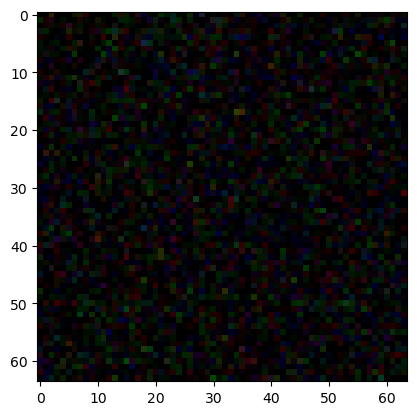

PyObject <matplotlib.image.AxesImage object at 0x00000000080F4670>

In [495]:
img = G(Z(128,1))
img = convert(Array{Float32}, value(img))
imshow(img)

In [29]:
# background = ObjectGenerator()
# foreground = ObjectGenerator()
# composedScene = max.(background, foreground)
# concat = reshape(composedScene, (16,16,16*64,1))
# c1 = Conv(1,1,1024,64)
# projected = c1(concat)


16×16×64×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0       0.111333  0.0       0.0        …  0.33001    0.0        0.0
 1.00384   0.0       0.0       0.0643006     0.0        0.370728   0.0
 0.422767  0.0       0.0       0.0           0.264088   0.0        0.393287
 0.0       1.33968   0.0       0.0           0.0        0.0        0.983215
 0.0       0.0       0.0       0.143648      0.0        0.0        0.340574
 0.0       0.205829  0.0       0.0        …  0.0101797  0.0        0.0
 0.0       0.0       0.0       0.527833      0.48742    0.0        1.00791
 0.0       1.17808   0.0       0.0           0.0        0.0        0.0
 0.0       2.14931   0.0       0.0           0.053772   0.0        0.0
 0.0       0.0       0.983323  0.0           0.0        0.510495   0.0
 0.0       0.0       0.0       0.0        …  0.0        0.0        0.0
 0.0       0.0       0.212154  0.0           0.0        0.113724   0.0
 0.0       0.0       0.0       0.0           0.0        0.0        0.0
 1.66186  

In [24]:
# a = Conv(1,1,1024,64)
# a(param(randn(16,16,1024,1)))

16×16×64×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 1.13547   0.033441  2.04341   0.0       …  0.0       0.0        0.678595
 2.00566   0.0       1.47031   0.0          0.209973  0.0        0.0
 0.102576  0.0       0.0       1.2225       2.20026   1.454      0.0
 0.0       0.568861  0.0       0.113073     0.0       1.83049    0.0
 0.0       2.64026   1.29375   0.0          3.05729   0.0        0.411401
 0.828501  1.64009   1.84639   0.0       …  0.0       0.0        0.513648
 1.90068   1.26037   0.141308  0.0          0.0       0.0        0.0
 0.953805  0.0       1.60803   0.562737     0.678362  2.23742    0.0
 0.197631  0.884353  0.0       1.40859      0.512996  1.1179     0.0
 2.01026   0.705277  0.0       0.222179     1.68262   1.35116    0.272887
 0.929535  0.537303  0.956694  1.21961   …  0.0       0.0294501  1.64141
 0.0       2.1019    0.555992  0.0          0.0       0.0        0.0
 0.0       0.719509  0.430889  1.18116      1.43637   1.47862    0.0
 0.370132  0.0       1.23364   

In [9]:
function ObjectGenerator()
    param(16,16,16,64)
end

ObjectGenerator (generic function with 1 method)

In [30]:
struct Deconv2; w; f; end
(c::Deconv2)(x) = c.f.(deconv4(c.w, x, padding = 0, stride = 2))
Deconv2(w1::Int,w2::Int,cx::Int,cy::Int,f=relu) = Deconv2(param(w1,w2,cx,cy),f)

Deconv2

In [11]:
# struct Deconv
#     w
#     b
#     function Deconv(filterSizeX::Int, filterSizeY::Int, nChannels::Int)
#         w = randn(filterSizeX, filterSizeY, nChannels)
#         b = zeros(filterSize, 1)
#         new(Param(w), Param(b))
#     end
# end

In [23]:
struct Conv; w; f; end
(c::Conv)(x) = c.f.(conv4(c.w, x, padding = 0, stride = 1))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu) = Conv(param(w1,w2,cx,cy),f)

Conv

In [13]:
# struct Generator
#     background
#     foreground
#     element_max
#     Concatenate
#     conv
#     upconv1
#     upconv2
#     upconv3
# end

In [25]:
struct Deconv; w; f; end
(c::Deconv)(x) = c.f.(deconv4(c.w, x, padding = 0, stride = 1))
Deconv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu) = Deconv(param(w1,w2,cx,cy),f)

Deconv

In [ ]:
# For 4d input
struct Dense; w; b; f; end
(d::Dense)(x) = d.f.(d.w * mat(x) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu) = Dense(param(o,i), param0(o), f)

In [27]:
# a = 3
# a(param(randn(16,16,1024,1)))

16×16×64×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0       0.0       0.0       0.0        …  0.0       0.0       2.3136
 1.11355   0.0       0.0       0.0           1.3074    0.0       1.78763
 0.0       3.43131   0.0       0.0           0.469733  0.0       0.0
 0.772017  0.0       0.80964   1.0469        0.0       0.0       0.0
 1.509     1.47611   0.0       0.547486      0.0       0.0       0.0
 0.0       0.0       1.43111   2.07118    …  0.0       0.0       0.0
 0.0       1.3741    0.965698  0.775948      0.0       0.469228  0.566646
 0.44611   0.181138  2.56543   0.0116432     0.808221  0.0       0.0
 3.16855   0.0       0.0       0.0           0.0       0.0       0.0665335
 0.0       0.0       0.198053  0.0           0.589427  0.0       0.0
 2.38588   1.85486   0.12415   1.91237    …  0.0       0.0       1.72541
 1.03584   0.145103  1.47623   0.0           2.29299   1.25946   0.0
 0.0       0.0       0.0       0.0           0.0       0.0       1.56871
 2.39351   0.0       1.29967 

In [33]:
# c2 = Deconv2(4,4,64,64)
# out = c2(projected)

19×19×64×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.06208    0.265894   0.495422    …  0.339784   0.0         0.234587
 0.0568185  0.108414   0.0            0.204019   0.0         0.242404
 0.0605689  0.984221   1.10574        0.965279   0.0         0.0
 0.127674   0.301857   0.0302098      0.0        0.0         0.330062
 0.0        0.438629   0.401362       0.142138   0.358297    0.0
 0.0513354  0.680541   0.0         …  0.0        0.361507    0.223266
 0.0        0.548035   0.138269       0.303595   0.0         0.495789
 0.0        0.606143   0.617513       0.332527   0.562796    0.353458
 0.0        0.66817    1.25798        0.406031   0.616905    0.0
 0.0        0.794922   0.0            0.0590964  0.0185492   0.0
 0.0        0.0        0.224953    …  0.357717   0.0         0.21162
 0.217885   0.0        0.93838        1.99154    0.00548868  0.0
 0.0        0.168142   0.765238       0.804281   0.0         0.160878
 0.0        0.491761   0.16064        0.337105   0.0         0.0
 0.

train_discriminator! (generic function with 3 methods)

train_generator! (generic function with 2 methods)

In [116]:
# function Generator()
#     background = ObjectGenerator()
#     foreground = ObjectGenerator()
#     composedScene = max.(background, foreground)
#     concat = reshape(composedScene, (16,16,16*64,1))
#     projected = 
#     projected = deconv4(randn(1, 1, 64, 16*64), concat)
    
# end

Generator

In [117]:
# output = Generator()

16×16×64×1 Array{Float64,4}:
[:, :, 1, 1] =
 -23.1242    -9.50304    30.3123     …   17.0909   -42.9666    34.3435
 -33.5712   -19.5332     18.5086        -13.7116    -2.07607   16.0256
  -4.63909   35.0904    -21.7904         -6.4425    -7.92485  -26.6754
  -9.46873   -4.43236   -28.5608        -13.1479   -42.5505    12.0707
   2.12206   -5.37147     5.54935         7.21008   -0.49796    8.37625
 -51.2061     8.78939     4.95452    …  -25.4357   -45.5729   -50.7343
 -10.5811    17.0472    -11.5825        -68.2748     9.87445  -47.4709
 -36.2278   -12.7541      0.0536501      -8.10017   16.2747   -16.6875
 -35.8297   -18.7343     16.2288        -13.6589    17.6443    15.4014
   5.78907  -14.9958      8.69957       -11.0218    -7.58054   11.3442
  -5.05401  -18.6515      2.65811    …   11.8488    35.2535     2.28959
  26.2363   -55.4425    -11.8667         -8.19189   -9.19645  -52.6541
 -27.7112    -0.955187   17.0883        -19.0405    30.3775     2.71892
  -6.73881  -71.3365    -43.66

In [77]:
# x = randn(16, 16, 16*64,1)
# w = randn(1, 1, 16*64, 64)
# y = conv4(w, x)

16×16×64×1 Array{Float64,4}:
[:, :, 1, 1] =
 -19.7216    65.231      22.5214   …   42.4017   -20.1838    -9.89653
 -28.0032   -15.0841     46.9117       40.7346     8.10759   47.9725
  -8.32633  -11.0709     43.9323      -43.8717    -2.78183    4.55433
  21.4259     0.102533  -11.2515        4.21327   -3.70247  -29.0258
 -27.5532    17.7193      3.41425     -47.1453    71.3451    -1.1307
 -44.3164   -36.8055     38.0259   …   27.9213     3.65025    7.72606
  27.7039   -29.204      19.6713      -12.594    -12.7816    15.1356
 -24.7761   -16.8721    -14.4455      -14.9723    68.2781     7.67317
  32.0289   -35.1947     26.3093       22.7927    34.7704   -17.1456
 -14.7215    14.7318    -33.2046       10.7668     8.66632    5.11931
   2.75515   14.8282     -4.04959  …  -19.6628    14.1892    45.5728
  48.4668   -32.3578    -72.6382        7.03184   24.5314   -14.2772
  46.5685    21.2506    -33.4785       16.9679    49.2914    38.9828
 -60.8831    33.2724     22.9286      -12.6761   -38.0

In [86]:
# x = randn(16, 16, 16*64, 1)
# w = randn(1, 1, 64, 16*64)
# y = deconv4(w, x)

16×16×64×1 Array{Float64,4}:
[:, :, 1, 1] =
  41.1687  -21.2313     6.43535   …   31.9485   -12.5988    21.9147
 -15.3488  -12.9305   -28.407         42.128    -34.8528    33.3113
 -36.2156  -26.5842    -5.3665        -7.5876   -41.134    -32.6837
  62.792    65.4765    -0.756294     -69.4366   -46.041     13.1602
  62.779   -36.3865    19.0791       -21.2482    20.8434    36.9835
  43.0161    2.81485   -0.710401  …   12.7327    17.8844    24.6805
 -12.9966   44.2403   -44.1296       -12.268    -16.2281    88.5513
  49.9913   14.0089    16.5421        -9.02667  -48.2597   -38.8263
  36.6823  -40.7765    -4.09214      -17.3608    35.6835   -19.5344
 -16.5967   53.5668     4.41911      -48.4958   -77.118     10.844
  36.4009  -31.5965   -67.8356    …   -9.88382  -17.5629    32.2485
  16.5396   -2.03321  -10.4416       -15.1104    -9.34157   62.1447
 -15.3629   19.9964   -12.3754       -21.9432    62.6001    24.1463
  13.7901  -35.3844   -81.2393       -16.6532    32.3623    -6.50953
  40

In [60]:
# size(y)

(16, 16, 1, 1)

In [8]:
# function make_minibatch(names, batchSize = 128)
#     rem = mod(length(names), batchSize)
#     names = reshape(names[1:end-rem], :, batchSize)
# end

# batches = make_minibatch(singleObj, 64)
# batch = load_batch(batches, 1)

156×64 Array{String,2}:
 "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_test_000000_0.png"  …  "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_val_001824_0.png"
 "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_test_000001_0.png"     "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_val_001825_0.png"
 "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_test_000002_0.png"     "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_val_001826_0.png"
 "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_test_000003_0.png"     "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_val_001827_0.png"
 "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_test_000004_0.png"     "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_val_001828_0.png"
 "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_test_000005_0.png"  …  "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_val_001829_0.png"
 "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_test_000006_0.png"     "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_val_001830_0.png"
 "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_test_000007_0.png"     "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_val_001831_0.png"
 "GeNeVA-v1\\i-CLEVR\\images\\CLEVR_test_000008_0.png"     "GeNeVA-v1\\i-CLEVR\\

In [ ]:
# struct Conv
#     w
#     b
#     function Conv()
    
# end